1) Work out the Neyman-Pearson detection statistic for detecting a rectangular box located at position 555, with hight 1, size 100 in white gaussian noise (np.random.normal(0,1,$10^6$))
a) Write the statistical model for the two competing hypothesis (H0, H1)
b) If a false detection costs $10^4$ dollars, but a true detection gains you a dollar, what would be the detection bar?
c) Suppose that the hight of the rectangular box is unknown, what would you do? Is the test optimal ?
d) Suppose that the noise was complex (as in complex numbers), and that the boxed signal had a uniform "hight" that is a complex number of unknown magnitude and phase. What would you do? is the test optimal?
e) Suppose that the position of the box is unknown. How would you detect it then?
How would you compute the detection statistic at all positions at once using FFT?
What would be the detection bar in this situation, for the same financial conditions as in (Q1 b)? Use monte-carlo to set the bar. What is the equivalent look-elsewhere-effect? 
f) What is the amplitude of the box such that if we "inject" a signal with this amplitude, the detection probability is 50% [what about 10%, 99%, 99.99%]
g) What would you do if the size of the box is unknown, and can take any width between 2 bins and 500 bins? Use monte-carlo to set the bar. What is the equivalent look-elsewhere-effect? 

2) You are looking for the same box as in (1), but suppose that the noise is of the following form:
n(t) = np.random.normal(0,1,$10^6$) convolved with a normalized triangular shape of width 500 [normalized such that np.linalg.norm(triangle)=1].
a) Write a statistical model for the null (H0) and the alternative hypothesis (H1) in real space what is the Neyman-Pearson detection statistic you would compute? [use matrix notation]
b) Write a statistical model for the null (H0) and the alternative hypothesis (H1)  in Fourier space. what is the Neyman-Pearson detection statistic you would compute? Is it the same statistic? Simulate a signal and compute the score in several positions, both in real space and Fourier space, make sure you get the same number up to machine precision.
c) Are you more sensitive with this noise source, or in Q1? What is the amplitude of the box such that if we "inject" a signal with this amplitude, the detection probability is 50% [what about 10%, 99%, 99.99%]?
(d) about the 50% detection amplitude as a function of the Triangle's width. Can you compute it analytically? (good approximation is OK) 

3) You are looking for the same box as in (1), but suppose that the noise is of the following form:
n(t) = np.random.normal(0,1,$10^6$) convolved with a normalized filter of width 500 and unknown shape [normalized such that np.linalg.norm(filter)=1].
a) Is it possible to obtain a good estimator of the filter? [Read about the Welch method AFTER trying to solve it yourself]
b) What is the impact of using the best-estimate filter in the detection statistic computed in (2) ? Is this hampering detection at all?
c) Suppose instead of $10^6$ samples, you have only $10^4$ samples, how does this impact the precision of estimating the filter?  Is this hampering detection at all?

4) Suppose you have the same situation as in (2), but after generating the noise, Gargamel chooses at random $10^3$ samples and zeroizes them.
a) Compute the statistic from (2) in this situation, and plot their histogram. Is that the same histogram as in (2)? Would this interfere with detection?
b) Write the time-domain statistic relevant for detecting a signal at a particular place, taking the missing data into account.

In [15]:
# CODE TO BE RUN ON STARTUP - functions also defined later when used
import numpy as np
import numba
from numba import jit
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline as spline

from numpy.fft import fft
from numpy.fft import ifft
from numpy.fft import fftshift as centered

import scipy.signal as ssp
from scipy.signal import get_window as window
# call as window(('name' [, params]), L) 
# 'gaussian' (needs std), 'boxcar' for rect, 'triang', 'hamming', others
# ('tukey', alpha=0.5) for rectangular for 1-alpha of region,
# tapered at sides with cosine for alpha of region

@numba.vectorize([numba.float64(numba.complex128),numba.float32(numba.complex64)])
def abs2(x):
    return x.real**2 + x.imag**2

# monte carlo sampling of tests statistics under null hypothesis
#@jit(nopython=True)
def get_stats(N=1000000, tau=100, alpha=0.0001, nsamples=100000):
    ft_signal = np.fft.fft(np.concatenate([np.zeros(N-tau), np.ones(tau)]))
    stats = np.empty(nsamples)
    for i in np.arange(nsamples):
        stats[i] = max(abs2(np.fft.ifft(ft_signal * \
                                        np.fft.fft(np.random.normal(0, 1, N) + \
                                                   1j*np.random.normal(0, 1, N)))))
    return stats

# plot histogram of monte carlo samples 
def mc_hist(stats, N=1000000, tau=100, alpha=0.0001, nsamples=100000):
    plt.hist(stats, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
    plt.xlabel('max|z_0|^2')
    plt.ylabel('count')
    plt.title(str(nsamples) + ' MC samples with N=' + str(N) + \
              ', tau=' + str(tau) + ', alpha=' + str(alpha))
    plt.show(block=False)
    return

# get monte carlo samples of test statistics from file and analyze
def get_stats_file(filename, N=1000000, tau=100, alpha=0.0001):
    stats = np.genfromtxt(filename, delimiter=',')
    bar = np.quantile(stats, 1 - alpha)
    alpha_prime = np.exp(-bar / float(2*tau))
    lef_N = alpha_prime / alpha
    Nmc = np.size(stats)
    print(str(Nmc), ' samples of N=', str(N), ', tau=', str(tau), ', alpha=', \
          str(alpha), '\n[bar, alpha_prime, lef_N] = \n', [bar, alpha_prime, lef_N])
    mc_hist(stats, N=N, tau=tau, alpha=alpha, nsamples=Nmc)
    return stats

# plot histogram of monte carlo samples 
def mc_hist_alltau(stats, N=1000000, alpha=0.0001, nsamples=100000):
    plt.hist(stats, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
    plt.xlabel('$max_{n_s, \\tau} \\frac{|z_0|^2}{\\tau}$')
    plt.ylabel('count')
    plt.title(str(nsamples) + ' MC samples with $N=$' + str(N) + \
              ', $2 \\leq \\tau \\leq 500$, $\\alpha=$' + str(alpha))
    plt.show(block=False)
    return

# get monte carlo samples of test statistics from file and analyze
def get_stats_file_alltau(filename, N=1000000, alpha=0.0001):
    taustats = np.genfromtxt(filename, delimiter=',')
    bartau = np.quantile(taustats, 1 - alpha)
    alphatau = np.exp(-bartau / 2.0)
    lef_Ntau = alphatau / alpha
    Nmc = np.size(taustats)
    print(str(Nmc), ' samples of N=', str(N), ', alpha=', \
          str(alpha), '\n[bar, alpha_prime, lef_N] = \n', [bartau, alphatau, lef_Ntau])
    mc_hist_alltau(taustats, N=N, alpha=alpha, nsamples=Nmc)
    return taustats

# these jit wrappers do seems to shave a bit of computation time
@jit(nopython=True)
def Mv(mat, vec):
    return mat.dot(vec)

@jit(nopython=True)
def vdot(vec1, vec2):
    return np.dot(vec1,vec2)

@jit(nopython=True)
def Minv(mat):
    if np.linalg.matrix_rank(mat) < (mat[0]).size:
        print('ERROR: matrix is singular')
        return None
    else:
        return np.linalg.inv(mat)

# using moore-penrose inverse handles singular convolution matrix problem
@jit(nopython=True)
def Mpinv(mat):
    return np.linalg.pinv(mat)    

@jit(nopython=True)
def Mtrans(mat):
    return np.transpose(mat)

@jit(nopython=True)
def unitv(vec):
    return vec / np.linalg.norm(vec)

# "upright right triangle" (also isosceles, with equal sides making L-shape) -->
# right angle b/w base and left side (I think this is called "sawtooth" pulse)
@jit(nopython=True)
def get_tri_right(arr_size, tri_width, start=0):
    tri_r = np.zeros(arr_size)
    for j in np.arange(start, start + tri_width):
        tri_r[j] = tri_width - j
    return tri_r / np.linalg.norm(tri_r)

# "upright isosceles triangle" (also a right triangle, with hypotenuse as base)
# right angle b/w left and right sides (this one is definitely called "triangular")
@jit(nopython=True)
def get_tri_iso(arr_size, tri_width, start=0):
    tri_i = np.zeros(arr_size)
    iso_height = int(tri_width / 2)
    tri_i[start + iso_height] = iso_height
    for j in np.arange(start, start + iso_height):
        tri_i[iso_height - j] = iso_height - j
        tri_i[iso_height + j] = iso_height - j
    return tri_i / np.linalg.norm(tri_i)

# get WGN
@jit(nopython=True)
def get_wgn(arr_size):
    return np.random.normal(0,1,arr_size) + 1j*np.random.normal(0,1,arr_size)

# get real WGN
@jit(nopython=True)
def real_wgn(arr_size):
    return np.random.normal(0,1,arr_size)

# get unit height rectangular pulse signal
@jit(nopython=True)
def get_signal(arr_size, sig_width, start=0):
    over = arr_size - sig_width - start
    if over < 0:
        return np.concatenate((np.ones(-over), np.zeros(arr_size - sig_width), \
                               np.ones(sig_width + over)))
    else:
        return np.concatenate((np.zeros(start), np.ones(sig_width), np.zeros(over)))

# get \hat{s}_{n_s - n --> n} to be used in fft computation of z(n_s)
@jit(nopython=True)
def get_revsig(arr_size, sig_width):
    return np.concatenate((np.ones(1), np.zeros(arr_size - sig_width), \
                           np.ones(sig_width - 1)))

def get_revsig_ft(arr_size, sig_width):
    return np.fft.fft(get_revsig(arr_size, sig_width))

# get circular convolution matrix T (consistent w/fft)
# thus T_{i j} = vec[i - j] (with negative indices as interpreted by python giving
# the correct mod N boundary wrapping behavior of circular convolution)
@jit(nopython=True)
def get_tmat(vec):
    arr_size = vec.size
    mat = np.empty((arr_size, arr_size))
    mat[:,0] = vec
    for j in np.arange(1, arr_size):
        mat[:j,j] = vec[-j:]
        mat[j:,j] = vec[:arr_size-j]
    return mat

# this gives M = (T^{-1})^{T} T^{-1}
# using np.matmul (no numba support) faster than jit with np.dot
def get_mmat(vec):
    mat = Mpinv(get_tmat(vec))
    return np.matmul(np.transpose(mat), mat)

# get M.sigvec = (T^{-1})^{T} T^{-1} sigvec
@jit(nopython=True)
def get_time_svec(trivec, sigvec):
    mat = np.linalg.pinv(get_tmat(trivec))
    return (np.transpose(mat)).dot(mat.dot(sigvec))

# get F[sigvec]_k / |F[trivec]_k|^2 = F[M.sigvec]_k
def get_freq_svec(trivec, sigvec):
    return np.fft.fft(sigvec) / abs2(np.fft.fft(trivec))

# get D.sigvec = T^{-1} sigvec
@jit(nopython=True)
def get_time_stri(trivec, sigvec):
    return (np.linalg.pinv(get_tmat(trivec))).dot(sigvec)

# get F[sigvec]_k / F[trivec]_k = F[D.sigvec]_k
def get_freq_stri(trivec, sigvec):
    return np.fft.fft(sigvec) / np.fft.fft(trivec)

# get simulated signal in real space
@jit(nopython=True)
def simulate_signal(arr_size, sig_width, start=0, amp=1.0, phi=0.0):
    return amp * np.exp(1j*phi) * get_signal(arr_size, sig_width, start=start)


# to answer this, we first need to set the detection bar again using monte carlo
def get_H0stats(N=1000000, tau=100, tautri=500, nsamples=100000):
    # get \tilde{t}
    t_ft_cc = np.conj(np.fft.fft(get_tri_right(N, tautri)))
    # now under H_0, \tilde{x}_k = \tilde{t}_k * \tilde{w}_k
    # so F[Mx]_k = \tilde{t}_k * \tilde{w}_k / |\tilde{t}_k|^2 
    # = \tilde{w}_k / \tilde{t}_k^*
    ft_signal = np.fft.fft(np.concatenate((np.ones(1), np.zeros(N-tau), np.ones(tau-1))))
    stats = np.empty(nsamples)
    for i in np.arange(nsamples):
        stats[i] = max(abs2(np.fft.ifft(ft_signal * np.fft.fft(get_wgn(N)) / t_ft_cc)))
    return stats

# plot histogram of monte carlo samples 
def mc_H0hist(stats, N=1000000, tau=100, tautri=500, alpha=0.0001, nsamples=100000):
    plt.hist(stats, bins='auto', alpha=0.7, rwidth=0.85)
    plt.xlabel('max|z_0|^2')
    plt.ylabel('count')
    plt.title(str(nsamples) + ' MC samples with $N=$' + str(N) + ', $\\tau=$' + \
              str(tau) + ', $\\tau_{tri}=$' + str(tautri) + ', $\\alpha=$' + str(alpha))
    plt.show(block=False)
    return

# and to run this for 100k samples we will need to send it to a cluster
def get_H0stats_file(filename, N=1000000, tau=100, tautri=500, alpha=0.0001):
    s_tri = get_freq_stri(get_tri_right(N, tautri), get_signal(N, tau))
    stats = np.genfromtxt(filename, delimiter=',')
    bar = np.quantile(stats, 1 - alpha)
    alpha_prime = np.exp(-bar / float(2*np.sum(abs2(s_tri))/N))
    lef_N = alpha_prime / alpha
    Nmc = np.size(stats)
    print(str(Nmc), ' samples of N=', str(N), ', tau=', str(tau), ', tau_{tri}=', \
          str(tautri), ', alpha=', str(alpha), \
          '\n[bar, alpha_prime, lef_N] = \n', [bar, alpha_prime, lef_N])
    mc_H0hist(stats, N=N, tau=tau, tautri=tautri, alpha=alpha, nsamples=Nmc)
    return stats

def get_H0stats_alltau(N=1000000, tau_start=2, tau_end=500, tautri=500, nsamples=100000):
    t_ft = np.fft.fft(get_tri_right(N, tautri))
    taus = np.arange(tau_start, tau_end + 1)
    Nt = np.size(taus)
    ft_mults = np.empty((Nt, N), dtype=np.csingle)
    stnorms = np.empty(Nt)
    for j, tau in enumerate(taus):
        ft_revsig = np.fft.fft(np.concatenate((np.ones(1),np.zeros(N-tau),np.ones(tau-1))))
        stnorms[j] = np.sum(abs2(ft_revsig / t_ft)) / float(N)
        ft_mults[j] = ft_revsig / np.conj(t_ft)
    stats = np.empty(nsamples)
    taustats = np.empty(Nt)
    for i in np.arange(nsamples):
        w_ft =  np.fft.fft(np.random.normal(0, 1, N) + 1j*np.random.normal(0, 1, N))
        for j in np.arange(Nt):
            taustats[j] = np.max(abs2(np.fft.ifft(w_ft * ft_mults[j]))) / stnorms[j]
        stats[i] = np.max(taustats)
    return stats

# get monte carlo samples of test statistics from file and analyze
def get_H0stats_file_alltau(filename, N=1000000, tautri=500, alpha=0.0001):
    taustats = np.genfromtxt(filename, delimiter=',')
    bartau = np.quantile(taustats, 1 - alpha)
    alphatau = np.exp(-bartau / 2.0)
    lef_Ntau = alphatau / alpha
    Nmc = np.size(taustats)
    print(str(Nmc), ' samples of N=', str(N), ', tau_{tri}=', str(tautri), ', alpha=', \
          str(alpha), '\n[bar, alpha_prime, lef_N] = \n', [bartau, alphatau, lef_Ntau])
    plt.hist(taustats, bins='auto', alpha=0.7, rwidth=0.85)
    plt.xlabel('$max_{n_s, \\tau} |\\frac{z_0}{|s_{tri}|}|^2$')
    plt.ylabel('count')
    plt.title(str(Nmc) + ' MC samples with $N=$' + str(N) + ', $\\tau_{tri}=$' + \
              str(tautri) + ', $2 \\leq \\tau \\leq 500$, $\\alpha=$' + str(alpha))
    plt.show(block=False)
    return taustats

# get Q from L and R assuming you want to use all data points
# and have no segments with zero padding or wrapping
def Qfull(N, L, R=None):
    if R == None:
        R = int(L/2)
    return 1 + int((N - L)/R)

# get welch estimate of filter from 
# data = filter convolved with WGN 
# L is segment length, R is offset, so overlap is L-R
# Q is number of segments and o_m is window (assumed length L)
# need Q <= 1 + (data.size - L)/R
def welch_psd(data, o_m, L=None, R=None, Q=None):
    if L == None:
        L = o_m.size
    if R == None:
        R = int(L/2)
    if Q == None:
        Q = Qfull(data.size, L, R)
    Gkq = np.zeros(L)
    for q in np.arange(Q):
        Gkq += abs2(fft(o_m * data[q*R:q*R+L]))
    return Gkq / (2*Q*np.sum(abs2(o_m)))
# why do we need the factor of 2?

# OR use pre-packaged version!
#ssp.welch(x, fs=1.0, window='hanning', nperseg=256, noverlap=None, nfft=None, \
#          detrend='constant', return_onesided=True, scaling='density', axis=-1)
# noverlap=None gives nperseg/2 (50%), nfft=None gives nperseg
# WARNING - NEEDS TO BE MULTIPLIED BY 0.5 (even with return_onesided=False - WHY???)

def ssp_welch(data, o_m):
    freqs, ssp_psd = ssp.welch(data, window=o_m, return_onesided=False, detrend=False)
    return ssp_psd

# convert low res approx to full length = arr.size * factor
@jit(nopython=True)
def bins_to_resolution(arr, factor):
    new_arr = np.empty(arr.size * factor)
    for i, val in enumerate(arr):
        for j in np.arange(factor):
            new_arr[i*factor + j] = val
    return new_arr

b2r = bins_to_resolution

def psdplot(pxx, krange=1000):
    plt.plot(np.arange(-krange, krange+1), \
             centered(pxx)[int(pxx.size/2) - krange:int(pxx.size/2) + krange + 1])
    plt.xlabel('frequency number (k)')
    plt.ylabel('power ($|\\tilde{x}_k|^2$)')
    plt.title('power spectral density')
    plt.show(block=False)
    return

def psdplot2(pxx_est, pxx_tru, krange=1000):
    kk = np.arange(-krange, krange+1)
    nN = pxx_tru.size
    i0 = int(nN/2) - krange
    i1 = int(nn/2) + krange + 1
    plt.plot(kk, centered(b2r(pxx_est, int(nN/pxx_est.size)))[i0:i1])
    plt.plot(kk, centered(pxx_tru)[i0:i1])
    plt.legend(['estimate','exact'])
    plt.xlabel('frequency number (k)')
    plt.ylabel('power ($|\\tilde{x}_k|^2$)')
    plt.title('power spectral density')
    plt.show(block=False)
    return
    

# now let's compare the various welch estimates by computing test statistic
# N_mc times for each (L, R, Q, o_m) = (L, L/2, 2N/L - 1, o_m)
# get max|z|^2 from data and template s(tau) using window function o_m to estimate psd
# and providing revsig_ft_conj = np.conj(get_revsig_ft(N, tau))
def compute_stat_welch(data, revsig_ft_conj, o_m):
    psd = welch_psd(data, o_m)
    return np.max(abs2(np.fft.ifft(revsig_ft_conj * np.fft.fft(data) / \
                                   bins_to_resolution(psd, int(data.size / psd.size)))))

# get squared fractional error of psd estimate
def compute_msfe_welch(data, tru_psd, o_m):
    psd = welch_psd(data, o_m)
    return abs2((tru_psd - bins_to_resolution(psd, int(data.size / psd.size)))/tru_psd)

# return mean and variance of true_psd - welch_psd
def compute_mean_var_welch(data, tru_psd, o_m):
    dif = tru_psd - b2r(welch_psd(data, o_m), int(data.size / o_m.size))
    return np.array([np.mean(dif), np.var(dif)])

def camp(cc):
    return cc * np.exp(1j*2*np.pi*np.random.random())

def csig(cc, nn=1000000, tau=100):
    return camp(cc) * get_signal(nn, tau, start=np.random.randint(0,nn))

# get test stats with welch psd for setting detection bar
def welch_H0stats(N=10000, L=2000, otype='hanning', outname='welchH0stats.csv', \
                  tau=100, tautri=500, nsamples=10):
    R = int(L/2)
    Q = Qfull(N,L,R)
    qrange = np.arange(Q)
    wbin = int(N/L)
    o_m = window(otype, L)
    Qfactor = 1.0 / (2*Q*np.sum(abs2(o_m)))
    t_ft = fft(get_tri_right(N, tautri))
    revsig_ftcc = np.conj(get_revsig_ft(N, tau))
    stats = np.empty(nsamples)
    for i in np.arange(nsamples):
        x_ft = t_ft * fft(get_wgn(N))
        data = ifft(x_ft)
        Gkq = np.zeros(L)
        for q in qrange:
            Gkq += abs2(fft(o_m * data[q*R:q*R+L]))
        stats[i] = np.max(abs2(ifft(revsig_ftcc * x_ft / b2r(Gkq*Qfactor, wbin))))
    np.savetxt(outname, stats, delimiter=',')
    return stats

1) Work out the Neyman-Pearson detection statistic for detecting a rectangular box located at position 555, with height 1, size 100 in white gaussian noise (np.random.normal(0,1,$10^6$))

********
a) $\textbf{Write the statistical model for the two competing hypothesis (H0, H1)}$
********

we have a time series of $ N = 10^6 $ data points $ x_n, n = 0, 1, ..., N-1 $ 

the null hypothesis is that the data is white gaussian noise (WGN): $ w_n \sim N(0,1) $

the alternative hypothesis is that, in addition to WGN, the data contains a rectangular pulse of height $A$ and length $\tau$ starting at time $n_s$ (signal): $ s_n = A (\Theta[\tau + n_s - n] - \Theta[n_s - n]) \equiv A \hat{s}_n(\tau, n_s) $

where $ \Theta[j] = \sum_{k = j}^{\infty} \delta_{jk} $ is the discrete (inclusive) Heaviside step function, so we may also use the (left-inclusive) indicator function $ \mathbb{I}(j; a, b) \equiv Indicator[a \leq j < b] = \sum_{k = a}^{b-1} \delta_{j k} $ to write our unit-height pulse template:

$ \hat{s}_n(\tau, n_s) = \mathbb{I}(n; n_s, n_s + \tau) $

we first write these hypotheses as

$ H_0: x_n = w_n $

$ H_1(A, \tau, n_s): x_n = w_n + A \hat{s}_n(\tau, n_s) $

with likelihoods $ L[H|x] = P[x|H] = P[H|x] \frac{P[x]}{P[H]} $

and posterior probabilities $ P[H|x] = \frac{P[H]}{P[x]} $

since we know the noise distribution, we can compute

$ P[x|H_0] = P[w_n = x_n] = \prod_{n=0}^{N-1} \frac{e^{-\frac{x_n^2}{2}}}{\sqrt{2 \pi}} = (2 \pi)^{-\frac{N}{2}} e^{-\sum_{n=0}^{N-1} \frac{x_n^2}{2}} $

$ P[x|H_1(A, \tau, n_s)] = P[w_n = x_n - s_n] = \prod_{n=0}^{N-1} \frac{e^{-\frac{(x_n - s_n)^2}{2}}}{\sqrt{2 \pi}} = (2 \pi)^{-\frac{N}{2}} e^{-\sum_{n=0}^{N-1} \frac{(x_n - s_n)^2}{2}} $

and this gives us the likelihood ratio

$ \Lambda(A, \tau, n_s; x) \equiv \frac{P[x|H_1(A, \tau, n_s)]}{P[x|H_0]} = e^{-\frac{1}{2} \sum_{n=0}^{N-1} ((x_n - s_n)^2 - x_n^2)} = e^{\sum_{n=0}^{N-1} (x_n s_n - \frac{s_n^2}{2})} = e^{-\frac{\tau A^2}{2}} e^{A \sum_{n=0}^{N-1} x_n \hat{s}_n(\tau, n_s)} $

then we reject $H_0$ in favor of $H_1$ when

$ \Lambda(A, \tau, n_s; x) > \eta_{\Lambda} $

where the threshold (detection bar) $\eta_{\Lambda}$ is set by the requirement that

$ P[\Lambda(A, \tau, n_s; x) > \eta_{\Lambda} | H_0] = P[\Lambda(A, \tau, n_s; x_n = w_n) > \eta_{\Lambda}] = \alpha $

for our desired significance level (false detection rate) $\alpha$

the neyman-pearson lemma states that this test has the greatest power, $P[\Lambda(A, \tau, n_s; x) > \eta_{\Lambda} | H_1]$, of all statistical tests at level $\alpha$ because we are using the likelihood ratio to test a simple hypothesis (fully specified model parameters)

further, the lemma states that any monotonic function of the likelihood ratio gives a test statistic with equivalently optimal power at level $\alpha$, so we instead consider

$ \lambda(\tau, n_s; x) \equiv \frac{1}{A}(\ln \Lambda + \frac{\tau A^2}{2}) = \sum_{n=0}^{N-1} x_n \hat{s}_n(\tau, n_s) $

and we reject $H_0$ in favor of $H_1$ when

$ \lambda(\tau, n_s; x) > \eta_{\lambda}(\alpha) $

it is now straightforward to set the threshold $\eta_{\lambda}(\alpha)$ according to

$ P[\lambda(\tau, n_s; x) > \eta_{\lambda}(\alpha) | H_0] = \alpha $

because we can easily compute our test statistic under $H_0$,

$ \lambda(\tau, n_s; x_n = w_n) = \sum_{n=0}^{N - 1} w_n \hat{s}_n(\tau, n_s) = \sum_{n=n_s}^{n_s + \tau - 1} w_n $

and since $w_n$ are $i.i.d.$ standard gaussian RVs, the sum of $\tau$ such variables is also gaussian with mean zero and variance $\tau$, so

$ \frac{1}{\sqrt{\tau}} \lambda(\tau, n_s; x_n = w_n) = \frac{1}{\sqrt{\tau}} \sum_{n=n_s}^{n_s + \tau - 1} w_n \sim N(0,1) \implies $

$ P[\frac{\lambda(\tau, n_s; x)}{\sqrt{\tau}} > \frac{\eta_{\lambda}}{\sqrt{\tau}} | H_0] = 1 - \Phi(\frac{\eta_{\lambda}}{\sqrt{\tau}}) $

where $\Phi(z)$ is the standard gaussian CDF, defined in terms of the error function under mathematica conventions as

$\Phi(z) = \frac{1}{2} (1 + Erf(\frac{z}{\sqrt{2}}))$

thus we can find the threshold $\eta(\alpha)$ using our desired false alarm rate

$ \alpha = 1 - \Phi(\frac{\eta_{\lambda}}{\sqrt{\tau}}) = \frac{1}{2} (1 - Erf(\frac{\eta_{\lambda}}{\sqrt{2 \tau}})) \implies $

$ \frac{\eta_{\lambda}(\alpha)}{\sqrt{\tau}} = \sqrt{2} InverseErf(1 - 2 \alpha) $


********
b) $\textbf{If a false detection costs 10^4 dollars,}$

$\textbf{but a true detection gains you a dollar,}$

$\textbf{what would be the detection bar?}$
********

for cost $C_{FD}$ of false detection and benefit $B_{TD}$ of true detection, we set our false detection rate $ \alpha = \frac{B_{TD}}{C_{FD}} $

here we have $ \alpha = \frac{1}{10^4} \implies $

$ \frac{\eta_{\lambda}(\alpha)}{\sqrt{\tau}} = \sqrt{2} InverseErf(1 - 2*10^{-4}) = 3.71902 $

********
c) $\textbf{Suppose that the height of the rectangular box is unknown,}$

$\textbf{what would you do? Is the test optimal ?}$
********

for an unknown height A, we use the same test statistic $\lambda(\tau, n_s; x)$ from above (which does not depend on A)

it is still an optimal test because the karl-rubin theorem allows you to extend the neyman-pearson lemma from simple hypotheses to composite hypotheses in one unknown parameter (e.g., $ H_1: A > 0 $, as opposed to the simple hypothesis $ H_1: A = a $), under the conditions
(1) the likelihood ratio is monotonic non-decreasing in the data and 
(2) you use a sufficient test statistic which is a monotonic function of the likelihood ratio and independent of the unknown parameter

********
d) $\textbf{Suppose that the noise was complex (as in complex numbers),}$

$\textbf{and that the boxed signal had a uniform "height"} $

$\textbf{that is a complex number of unknown magnitude and phase.}$ 

$\textbf{What would you do? is the test optimal?}$
********

the simplest solution is to treat the real and imaginary components of our data separately, since they are completely independent, then we can use the same test described above and claim detection if either component's test statistic is above the threshold

however, since you would expect a false positive after $\frac{1}{\alpha}$ independent tests each at false positive rate $\alpha$, we should use false positive rate of approximately $\frac{\alpha}{2}$ for each test in order to preserve the overall rate of $\alpha$ after 2 tests

(more precisely, tests with false positive rates $\alpha_1$ and $\alpha_2$ combine for an overall false positive rate of $ \alpha = 1 - (1-\alpha_1)(1-\alpha_2) = \alpha_1 + \alpha_2 - \alpha_1 \alpha_2 $)

but the Neyman-Pearson lemma and Karlin-Rubin theorem don't guarantee that the overall test is uniformly most powerful for the two-parameter family of tests -- and in fact, it is NOT AN OPTIMAL TEST because a more powerful test can be found by revisiting the problem more carefully as follows: 

now we have complex WGN $ w_n \sim CN(0,2) \implies \Re(w_n), \Im(w_n) \sim N(0, 1)$

and we search for the complex signal $ s_n = A e^{i \phi} \hat{s}_n(\tau, n_s) $

using the hypotheses

$ H_0: x_n = w_n $

$ H_1(A, \phi, \tau, n_s): x_n = w_n + A e^{i \phi} \hat{s}_n(\tau, n_s) $

this gives us likelihood functions from the PDF of a circularly symmetric complex gaussian (variance = 2 from unit variance of i.i.d. real and imaginary parts)

$ P[x_n | H_0] = P[w_n = x_n] = \prod_n \frac{e^{-\frac{|x_n|^2}{2}}}{2 \pi} $

$ P[x_n | H_1(A, \phi, \tau, n_s)] = P[w_n = x_n - s_n] = \prod_n \frac{e^{-\frac{|x_n - s_n(A, \phi, \tau, n_s)|^2)}{2}}}{2 \pi} $

$ \implies $

$ \Lambda(A, \phi, \tau, n_s; x) = \frac{P[x_n | H_1(A, \phi, \tau, n_s)]}{P[x_n | H_0]} = e^{\sum_n \frac{|x_n|^2 - |x_n - s_n|^2}{2}} = e^{\sum_n (\Re(s_n^{*} x_n) - \frac{|s_n|^2}{2})} =  e^{-\frac{\tau A^2}{2}} e^{A \Re(e^{-i \phi} \sum_n x_n \hat{s}_n)} $

now define the complex statistic $ z(\tau, n_s; x) \equiv \sum_n x_n \hat{s}_n(\tau, n_s) = \sum_{n = n_s}^{n_s + \tau - 1} x_n $

which gives us $ \Lambda(A, \phi, \tau, n_s; x) = e^{-\frac{\tau A^2}{2}} e^{A \Re(e^{-i \phi} z(\tau, n_s; x))} = e^{-\frac{\tau A^2}{2}} e^{A |z| cos(arg(z) - \phi)} $

since the noise is circularly symmetric, it treats all pulse phases equally, so we marginalize over the phase $\phi$ (using a uniform distribution from $0$ to $2 \pi$ as its prior) to get 

$ \Lambda(A, \tau, n_s; x) = e^{-\frac{\tau A^2}{2}} \int_0^{2 \pi} \frac{d\phi}{2 \pi} e^{A |z| cos(arg(z) - \phi)} = e^{-\frac{\tau A^2}{2}} I_0(A |z(\tau, n_s; x)|) $

where $ I_0(y) = \sum_{k = 0}^{\infty} \frac{(\frac{y^2}{4})^k}{(k!)^2} $ is the $0^{th}$-order modified bessel function of the $1^{st}$ kind

noting that $e^{A^2 |z|^2}$ is an upper envelope of $I_0(A |z|)$, we see $\frac{e^{A^2 |z|^2}}{I_0(A |z|)}$ is monotonic non-decreasing in $|z| > 0$, and since the likelihood ratio is again monotonic non-decreasing in the data we can define

$ \lambda(\tau, n_s; x) \equiv \frac{1}{A^2}(\ln(\frac{e^{A^2 |z|^2}}{I_0(A |z|)} \Lambda(A, \tau, n_s; x)) + \frac{\tau A^2}{2}) = |z(\tau, n_s; x)|^2 $

to be our test statistic that is optimal according to neyman-pearson and karl-rubin

that is, our test rejects $H_0$ in favor of $H_1$ when $ \lambda(\tau, n_s; x) > \eta_{\lambda} $, and choosing $\eta_{\lambda}$ such that $ P[\lambda(\tau, n_s; x) > \eta_{\lambda}(\alpha) | H_0] = \alpha $ gives us the most powerful test at significance level $\alpha$ (following the neyman-pearson lemma and karl-rubin theorem)

finally, it is straightforward to determine $\eta_{\lambda}(\alpha)$ because we have

$ \lambda(\tau, n_s; x) = |z(\tau, n_s; x)|^2 = |\sum_n x_n \hat{s}_n(\tau, n_s)|^2 $

$ \implies \frac{1}{\tau} \lambda(\tau, n_s; x) = \frac{|z|^2}{\tau} = (\frac{\Re(z)}{\sqrt{\tau}})^2 + (\frac{\Im(z)}{\sqrt{\tau}})^2 $

then defining $ z_0(\tau, n_s) \equiv z(\tau, n_s; x_n = w_n) $ to be the complex statistic $z(\tau, n_s; x)$ under $H_0$ we have 

$ z_0(\tau, n_s) = \sum_{n = n_s}^{n_s + \tau - 1} w_n \sim CN(0,2 \tau) \implies \Re(z_0), \Im(z_0) \sim N(0, \tau) $

$ \implies \frac{\Re(z_0)}{\sqrt{\tau}}, \frac{\Im(z_0)}{\sqrt{\tau}} \sim N(0, 1) $

and therefore under the null hypothesis $H_0$ we have

$ \frac{1}{\tau} \lambda(\tau, n_s; x_n = w_n) = \frac{|z_0|^2}{\tau} = (\frac{\Re(z_0)}{\sqrt{\tau}})^2 + (\frac{\Im(z_0)}{\sqrt{\tau}})^2 \sim \chi^2(2) $

where $\chi^2(k)$ is the chi-squared distribution with $k$ degrees of freedom, obtained from summing the squares of $k$ standard gaussian RVs, which has a particularly simple CDF for $k = 2$:

$ F_{\chi^2(2)}(y) = 1 - e^{-\frac{y}{2}} \implies F_{\chi^2(2)}^{-1}(p) = -2 \ln(1 - p) $

thus we get

$ P[\frac{\lambda(\tau, n_s; x)}{\tau} > \frac{\eta_{\lambda}(\alpha)}{\tau} | H_0] = P[\chi^2(2) > \frac{\eta_{\lambda}(\alpha)}{\tau}] = 1 - F_{\chi^2(2)}(\frac{\eta_{\lambda}(\alpha)}{\tau}) = \alpha \implies $

$ \frac{\eta_{\lambda}(\alpha)}{\tau} = F_{\chi^2(2)}^{-1}(1 - \alpha) = -2 \ln(\alpha) $

so

$ \frac{\eta_{\lambda}(\alpha = 10^{-4})}{\tau} = 8 \ln(10) = 18.4207 $


********
e) $\textbf{Suppose that the position of the box is unknown. How would you detect it then?}$

$\textbf{How would you compute the detection statistic at all positions at once using FFT?}$

$\textbf{What would be the detection bar in this situation, for the same financial conditions as in (Q1 b)?}$

$\textbf{Use monte-carlo to set the bar. What is the equivalent look-elsewhere-effect? }$
********

similar to the phase of the pulse, the noise treats all pulse starting times $n_s$ equally and the prior distribution can be taken to be uniform over all possible start times (which in the context of $H_1$ means that $ n_s = 0, 1, ..., N-1 $ all have probability $\frac{1}{N}$), so we could marginalize the likelihood ratio over $n_s$ to get

$ \Lambda(A, \tau; x) = e^{-\frac{\tau A^2}{2}} \sum_{n_s = 0}^{N - 1} \frac{I_0(A |z(\tau, n_s; x)|)}{N} $

however, the structure of this sum does not admit an analytic procedure for obtaining a test statistic that is independent of the pulse amplitude $A$, so if we want to keep our hypothesis test agnostic with respect to $A$ we must adopt another approach

the standard approach to circumventing the marginalization of the likelihood ratio is to maximize the likelihood ratio over the variable to be marginalized, and since the same $n_s$ that maximizes $\Lambda(A, \tau, n_s; x)$ will maximize a monotonic function of this unmarginalized likelihood ratio, we can simply use

$ \lambda(\tau; x) \equiv max_{n_s} \lambda(\tau, n_s; x) = max_{n_s} |z(\tau, n_s; x)|^2 $

as our test statistic, and our new test rejects $H_0$ in favor of $H_1$ when $ \lambda(\tau; x) > \eta_{\lambda} $, with $\eta_{\lambda}(\alpha)$ such that $ P[\lambda(\tau; x) > \eta_{\lambda}(\alpha) | H_0] = \alpha $

this raises two practical computation questions, because we have to compute $z(\tau, n_s; x)$ for every value of $n_s$ to get $ \lambda(\tau; x) = max_{n_s} |z|^2 $, and we have to find the distribution of $\lambda(\tau; x)$ under the null hypothesis $H_0$ to get $\eta_{\lambda}(\alpha)$

the first question can be addressed by noting that 

$ z(\tau, n_s; x) = \sum_n x_n \hat{s}_n(\tau, n_s) = \sum_n x_n \hat{s}_{n_s - n}(\tau) $

is in fact the discrete convolution of the data $x_n$ with the shifted and reversed unit pulse $\hat{s}_{(n_s - n) \rightarrow n}(\tau) = \mathbb{I}(n; -\tau, 0) $ whose $\textit{right}$ edge is now at $n = -1$ (or $n = 0$ depending on convention)

since the fourier transform of a convolution is the product of the individual fourier transforms, we can write this as 

$ z(\tau, n_s; x) = F^{-1}[F[x_n]_k F[\hat{s}_{(n_s - n) \rightarrow n}(\tau)]_k]_{n_s} $

where the discrete fourier transform $F[y_n]_k$ and its inverse $F^{-1}[\tilde{y}_k]_n$ can be computed efficiently using an fft algorithm

the only issue is that we need to decide how to extend our domain outside $ 0 \leq n < N $ for the edge cases where $ -\tau < n_s < 0 $ or $ N - \tau < n_s < N $, which is immediately obvious from the fourier transform description because the only nonzero values of $\hat{s}_{(n_s - n) \rightarrow n}(\tau)$ are for $ -\tau \leq n < 0 $

ERROR: apparently, to make the indices match up it should be that $\hat{s}_{(n_s - n) \rightarrow n}(\tau)$ has its nonzero values for $ -\tau < n \leq 0 $, because the substitution $ (n_s - n) \rightarrow n $ works differently in the heaviside step function representation than it does in the indicator function representation, and the DFT uses the latter while I was using the former --> I will not adjust this for question 1 because of the translation invariance of the test statistic (which takes maximum over $n_s$), but for later questions this will be relevant

we could deal with this in two ways:
(1) make the index wraps around (periodic summation) so that $f_n \equiv f_{n \, mod \, N}$, or (2) add $\tau$ zeros to each end of the data and use a vector of size $N + 2 \tau$ to represent the templates $\hat{s}_n(\tau, -\tau < n_s < N)$ over indices $ -\tau \leq n < N + \tau $

although (2) is the more physical solution, given the artificial nature of the problem we will use method (1), which is more computationally convenient

thus, we have an efficient way to compute $z(\tau, n_s; x)$ for all $n_s$, and now we address the question of finding the distribution of our test statistic under the null hypothesis $H_0$,

$ \lambda(\tau; x_n = w_n) = max_{n_s} |z_0(\tau, n_s)|^2 $

so that we can choose $\eta_{\lambda}(\alpha)$ such that $ P[\lambda(\tau; x_n = w_n) > \eta_{\lambda}(\alpha)] = \alpha $

if we had $ \tau = 1 $, then $z_0(\tau, n_s)$ would be independent for different values of $n_s$, and we could think of maximizing over all $N$ values of $n_s$ like doing $N$ independent tests of the same hypothesis

as noted earlier, when you do $N$ independent trials of the same test, you expect that events of probability $\frac{1}{N}$ might occur, so if you want an overall false alarm rate $\alpha$ to be preserved, you should set the detection bar such that the false alarm rate for each individual test is $ \alpha LEF(N) \approx \frac{\alpha}{N} $, where the factor $LEF(N)$ accounts for this so-called "look-elsewhere effect"

to find $LEF(N)$ for our case, in which the $N$ tests are highly correlated, we will use monte carlo simulation to empirically build the distribution of $\lambda(\tau; x_n = w_n)$ by storing its values for a large number $N_{mc}$ of WGN data realizations, then we will set the detection bar $\eta_{\lambda}(\alpha)$ to be the boundary of the $(1 - \alpha)$-quantile in our set of $N_{mc}$ sampled values of $\lambda(\tau; x_n = w_n)$

to obtain an acceptable approximation of the $(1 - \alpha)$-quantile, we will take $ N_{mc} = \frac{10}{\alpha} $, and once we have $\eta_{\lambda}(\alpha)$ we can get the false alarm rate $ \alpha' = 1 - F_{\chi^2(2)}(\frac{\eta_{\lambda}(\alpha)}{\tau}) = e^{-\frac{\eta_{\lambda}(\alpha)}{2 \tau}} $ that would be achieved by using this detection bar as the threshold for testing a single value of $n_s$, which gives us

$ LEF(N) = \frac{\alpha'}{\alpha} $

or we could say that the effective number of independent tests we are doing is

$ NIT_{eff} =  \frac{\alpha}{\alpha'} = \frac{1}{LEF(N)} $

In [1]:
import numpy as np
import numba
from numba import jit
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline as spline

from numpy.fft import fft
from numpy.fft import ifft

@numba.vectorize([numba.float64(numba.complex128),numba.float32(numba.complex64)])
def abs2(x):
    return x.real**2 + x.imag**2

# monte carlo sampling of tests statistics under null hypothesis
#@jit(nopython=True)
def get_stats(N=1000000, tau=100, alpha=0.0001, nsamples=100000):
    ft_signal = np.fft.fft(np.concatenate([np.zeros(N-tau), np.ones(tau)]))
    stats = np.empty(nsamples)
    for i in np.arange(nsamples):
        stats[i] = max(abs2(np.fft.ifft(ft_signal * \
                                        np.fft.fft(np.random.normal(0, 1, N) + \
                                                   1j*np.random.normal(0, 1, N)))))
    return stats

# plot histogram of monte carlo samples 
def mc_hist(stats, N=1000000, tau=100, alpha=0.0001, nsamples=100000):
    plt.hist(stats, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
    plt.xlabel('max|z_0|^2')
    plt.ylabel('count')
    plt.title(str(nsamples) + ' MC samples with N=' + str(N) + \
              ', tau=' + str(tau) + ', alpha=' + str(alpha))
    plt.show(block=False)
    return

# get monte carlo samples of test statistics from file and analyze
def get_stats_file(filename, N=1000000, tau=100, alpha=0.0001):
    stats = np.genfromtxt(filename, delimiter=',')
    bar = np.quantile(stats, 1 - alpha)
    alpha_prime = np.exp(-bar / float(2*tau))
    lef_N = alpha_prime / alpha
    Nmc = np.size(stats)
    print(str(Nmc), ' samples of N=', str(N), ', tau=', str(tau), ', alpha=', \
          str(alpha), '\n[bar, alpha_prime, lef_N] = \n', [bar, alpha_prime, lef_N])
    mc_hist(stats, N=N, tau=tau, alpha=alpha, nsamples=Nmc)
    return stats

N = 10**6
tau = 100
alpha = 10**(-4)
nsamples = int(10/alpha)

100000  samples of N= 1000000 , tau= 100 , alpha= 0.0001 
[bar, alpha_prime, lef_N] = 
 [4297.731706898745, 4.651512313561326e-10, 4.651512313561326e-06]


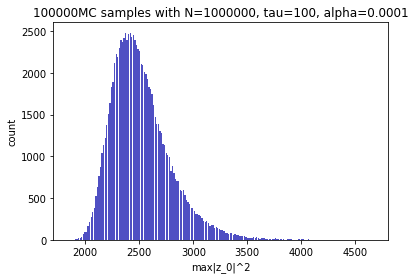

In [40]:
# or if we already wrote stats by sending it to a cluster:
s10e6t100 = get_stats_file('max10e6t100_stats.csv', N=1000000, tau=100, alpha=alpha)

1000000  samples of N= 100000 , tau= 100 , alpha= 0.0001 
[bar, alpha_prime, lef_N] = 
 [3859.8521238956787, 4.153723735013579e-09, 4.153723735013579e-05]


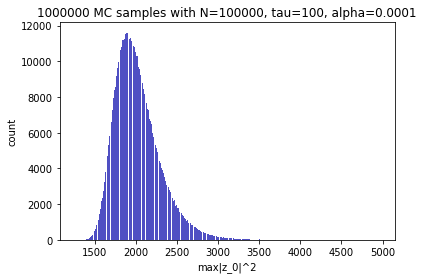

In [238]:
# lets do this with 100/alpha samples for better stats
more_s10e5t100 = get_stats_file('max10e5t100_stats_1M.csv', \
                                N=100000, tau=100, alpha=alpha)

1000000  samples of N= 100000 , tau= 100 , alpha= 0.0001 
[bar, alpha_prime, lef_N] = 
 [4315.368374732655, 4.2588921010332785e-10, 4.258892101033278e-06]


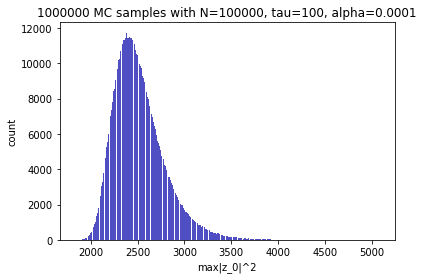

In [239]:
# and for 10^6 samples of N = 10^6, courtesy of feynman cluster
more_s10e6t100 = get_stats_file('max10e6t100_stats_1M.csv', \
                                N=100000, tau=100, alpha=alpha)

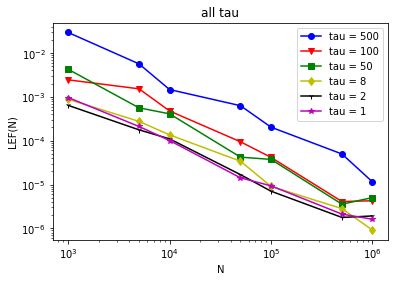

In [240]:
# and let's take a more systematic look at the look-elsewhere effect
# as a function of sample size N and template width tau
n1 = []
lef1 = []
n2 = []
lef2 = []
n8 = []
lef8 = []
n50 = []
lef50 = []
n100 = []
lef100 = []
n500 = []
lef500 = []
kw1 = [{'N' : 1000, 'tau' : 1, 'outname' : 'max1te3_stats.csv'}, \
       {'N' : 5000, 'tau' : 1, 'outname' : 'max1t5e3_stats.csv'}, \
       {'N' : 10000, 'tau' : 1, 'outname' : 'max1te4_stats.csv'}, \
       {'N' : 50000, 'tau' : 1, 'outname' : 'max1t5e4_stats.csv'}, \
       {'N' : 100000, 'tau' : 1, 'outname' : 'max1te5_stats.csv'}, \
       {'N' : 500000, 'tau' : 1, 'outname' : 'max1t5e5_stats.csv'}, \
       {'N' : 1000000, 'tau' : 1, 'outname' : 'max1te6_stats.csv'}]
kw2 = [{'N' : 1000, 'tau' : 2, 'outname' : 'max2te3_stats.csv'}, \
       {'N' : 5000, 'tau' : 2, 'outname' : 'max2t5e3_stats.csv'}, \
       {'N' : 10000, 'tau' : 2, 'outname' : 'max2te4_stats.csv'}, \
       {'N' : 50000, 'tau' : 2, 'outname' : 'max2t5e4_stats.csv'}, \
       {'N' : 100000, 'tau' : 2, 'outname' : 'max2te5_stats.csv'}, \
       {'N' : 500000, 'tau' : 2, 'outname' : 'max2t5e5_stats.csv'}, \
       {'N' : 1000000, 'tau' : 2, 'outname' : 'max2te6_stats.csv'}]
kw8 = [{'N' : 1000, 'tau' : 8, 'outname' : 'max8te3_stats.csv'}, \
       {'N' : 5000, 'tau' : 8, 'outname' : 'max8t5e3_stats.csv'}, \
       {'N' : 10000, 'tau' : 8, 'outname' : 'max8te4_stats.csv'}, \
       {'N' : 50000, 'tau' : 8, 'outname' : 'max8t5e4_stats.csv'}, \
       {'N' : 100000, 'tau' : 8, 'outname' : 'max8te5_stats.csv'}, \
       {'N' : 500000, 'tau' : 8, 'outname' : 'max8t5e5_stats.csv'}, \
       {'N' : 1000000, 'tau' : 8, 'outname' : 'max8te6_stats.csv'}]
kw50 = [{'N' : 1000, 'tau' : 50, 'outname' : 'max10e3t50_stats.csv'}, \
        {'N' : 5000, 'tau' : 50, 'outname' : 'max5x10e3t50_stats.csv'}, \
        {'N' : 10000, 'tau' : 50, 'outname' : 'max10e4t50_stats.csv'}, \
        {'N' : 50000, 'tau' : 50, 'outname' : 'max5x10e4t50_stats.csv'}, \
        {'N' : 100000, 'tau' : 50, 'outname' : 'max10e5t50_stats.csv'}, \
        {'N' : 500000, 'tau' : 50, 'outname' : 'max5x10e5t50_stats.csv'}, \
        {'N' : 1000000, 'tau' : 50, 'outname' : 'max10e6t50_stats.csv'}]
kw100 = [{'N' : 1000, 'tau' : 100, 'outname' : 'max10e3t100_stats.csv'}, \
         {'N' : 5000, 'tau' : 100, 'outname' : 'max5x10e3t100_stats.csv'}, \
         {'N' : 10000, 'tau' : 100, 'outname' : 'max10e4t100_stats.csv'}, \
         {'N' : 50000, 'tau' : 100, 'outname' : 'max5x10e4t100_stats.csv'}, \
         {'N' : 100000, 'tau' : 100, 'outname' : 'max10e5t100_stats_1M.csv'}, \
         {'N' : 500000, 'tau' : 100, 'outname' : 'max5x10e5t100_stats.csv'}, \
         {'N' : 1000000, 'tau' : 100, 'outname' : 'max10e6t100_stats_1M.csv'}]
kw500 = [{'N' : 1000, 'tau' : 500, 'outname' : 'max10e3t500_stats.csv'}, \
         {'N' : 5000, 'tau' : 500, 'outname' : 'max5x10e3t500_stats.csv'}, \
         {'N' : 10000, 'tau' : 500, 'outname' : 'max10e4t500_stats.csv'}, \
         {'N' : 50000, 'tau' : 500, 'outname' : 'max5x10e4t500_stats.csv'}, \
         {'N' : 100000, 'tau' : 500, 'outname' : 'max10e5t500_stats.csv'}, \
         {'N' : 500000, 'tau' : 500, 'outname' : 'max5x10e5t500_stats.csv'}, \
         {'N' : 1000000, 'tau' : 500, 'outname' : 'max10e6t500_stats.csv'}]

for kw in kw1:
    n1.append(kw['N'])
    stats = np.genfromtxt(kw['outname'], delimiter=',')
    bar = np.quantile(stats, 1 - alpha)
    lef1.append(np.exp(-bar / 2.0) / alpha)
for kw in kw2:
    n2.append(kw['N'])
    stats = np.genfromtxt(kw['outname'], delimiter=',')
    bar = np.quantile(stats, 1 - alpha)
    lef2.append(np.exp(-bar / 4.0) / alpha)
for kw in kw8:
    n8.append(kw['N'])
    stats = np.genfromtxt(kw['outname'], delimiter=',')
    bar = np.quantile(stats, 1 - alpha)
    lef8.append(np.exp(-bar / 16.0) / alpha)
for kw in kw50:
    n50.append(kw['N'])
    stats = np.genfromtxt(kw['outname'], delimiter=',')
    bar = np.quantile(stats, 1 - alpha)
    lef50.append(np.exp(-bar / 100.0) / alpha)
for kw in kw100:
    n100.append(kw['N'])
    stats = np.genfromtxt(kw['outname'], delimiter=',')
    bar = np.quantile(stats, 1 - alpha)
    lef100.append(np.exp(-bar / 200.0) / alpha)
for kw in kw500:
    n500.append(kw['N'])
    stats = np.genfromtxt(kw['outname'], delimiter=',')
    bar = np.quantile(stats, 1 - alpha)
    lef500.append(np.exp(-bar / 1000.0) / alpha)
    
plt.figure(555)
plt.loglog(n500, lef500, marker='o', color='b')
plt.loglog(n100, lef100, marker='v', color='r')
plt.loglog(n50, lef50, marker='s', color='g')
plt.loglog(n8, lef8, marker='d', color='y')
plt.loglog(n2, lef2, marker='1', color='k')
plt.loglog(n1, lef1, marker='*', color='m')
plt.legend(['tau = 500','tau = 100','tau = 50','tau = 8','tau = 2','tau = 1'])
plt.xlabel('N')
plt.ylabel('LEF(N)')
plt.title('all tau')
plt.show(block=False)

if appears that for $\tau = 100$ the effective number of independent samples is roughly between $\frac{N}{5}$ and $\frac{N}{4}$ when we search for the pulse at all $N = 10^5$ or $10^6$ starting positions 

********
f) $\textbf{What is the amplitude of the box such that if we "inject" a signal with this amplitude,}$

$\textbf{the detection probability is .5? (what about .1, .99, .9999?)}$
********

the detection probability for an injection $ s_n(A_I, \phi_I, \tau_I, n_{sI}) $ is given by

$ \Pi(A_I, \phi_I, \tau_I, n_{sI}) \equiv P[\lambda(\tau; x_n = w_n + s_n(A_I, \phi_I, \tau_I, n_{sI})) > \eta_{\lambda}(\alpha)] = $

$ P[max_{n_s} | \sum_n \hat{s}_n(\tau, n_s) (w_n + A_I e^{i \phi_I} \hat{s}_n(\tau_I, n_{sI}))|^2 > \eta] = $

$ P[max_{n_s} |z_0(\tau, n_s) + A_I e^{i \phi_I} \sum_n \hat{s}_n(\tau, n_s) \hat{s}_n(\tau_I, n_{sI})|^2 > \eta] = $

$ P[max_{n_s} (|z_0(\tau, n_s)|^2 + 2 A_I \sigma(\tau, n_s; \tau_I, n_{sI}) \Re(e^{-i \phi_I} z_0(\tau, n_s)) + A_I^2 \sigma(\tau, n_s; \tau_I, n_{sI})^2) > \eta] $

where 

$ \sigma(\tau, n_s; \tau_I, n_{sI}) \equiv \sum_n \hat{s}_n(\tau, n_s) \hat{s}_n(\tau_I, n_{sI}) = \sum_n \mathbb{I}(n; n_s, n_s + \tau) \mathbb{I}(n; n_{sI}, n_{sI} + \tau_I) $

defining $ \tau_{min} \equiv min(\tau, \tau_I) $ and $ \Delta \tau \equiv |\tau - \tau_I| $, we see that $\sigma(\tau, n_s; \tau_I, n_{sI})$ is a trapezoidal pulse (in $n_s$) which is zero for $ n_s \leq n_{sI} - \tau $, then, starting from unit height at $ n_s = n_{sI} - (\tau - 1) $, it rises with unit slope until it reaches its maximal height $\tau_{min}$ at $ n_s =  n_{sI} - \tau + \tau_{min} = n_{sI} - max(0, \tau - \tau_I) $, and it remains at its maximal height for a total of $ \Delta \tau + 1 $ points up to and including $ n_s = n_{sI} - \tau + \tau_{min} + \Delta \tau = n_{sI} + max(0, \tau_I - \tau) $, after which it decreases with unit slope until it again reaches unit height at $ n_s = n_{sI} + (\tau_I - 1) $ and then returns to zero for $ n_s \geq n_{sI} + \tau_I $


now to find $\Pi(A_I, \phi_I, \tau_I, n_{sI})$ as a function of $A_I$ we will use the following monte carlo procedure:

select some uniformly discretized interval $ \lbrace A_{Imin}, 2 A_{Imin}, 3 A_{Imin}, ..., A_{Imax} \rbrace $ such that $ \Pi(A_{Imin}) \approx \Pi(0) = \alpha $ and $ \Pi(A_{Imax}) \approx \Pi(\infty) = 1 $

generate some large number $N_{mc}$ of WGN realizations, and for each value of $A_I$ count how many of those noise realizations result in a test statistic that passes the detection bar

dividing these counts by $ N_{mc} $ gives $ \Pi(A_{I}) $ for each amplitude in our discretized interval, from which we can interpolate the power function and find the amplitude $A_{0.5}$ such that $\Pi = 0.5$

a computationally efficient method for doing this is to iterate over the $N_{mc}$ noise realizations just once, and for each WGN sample start at $A_{Imin}$ and compute the test statistic of each successive $A_I$ in the discretized interval until reaching the first amplitude $A_{Ibar}$ that passes the bar, then increment the counts of all $ A_I \geq A_{Ibar} $ and move on to the next noise sample

the final detail to be addressed is how to select the other injection parameters $(\phi_I, \tau_I, n_{sI})$

the choice of $\tau_I$ is really a matter of what the question is asking for, and since the question doesn't clarify this point, it's natural to assume that it means for the injected signal to have the same shape as the template, so we will take $\tau_I = \tau$, which makes $\sigma(\tau, n_s; \tau_I=\tau, n_{sI})$ a triangular pulse (i.e., the top of the trapezoid includes only one point) with peak height $\tau$ at $ n_s = n_{sI} $ and unit height endpoints at $ n_s = n_{sI} \pm (\tau - 1) $

the choice of injection phase is arbitrary since the noise is circularly symmetric, so simply selecting the convenient phase $ \phi_I = 0 $ is equivalent to drawing it at random for each noise sample

the choice of start time could have some effect in the physical case where we allowed the pulse to extend off the ends of the time series, but under our periodic boundaries the choice of injection start time is as inconsequential as the phase, so instead of drawing it at random for each sample we will simply use $ n_{sI} = \frac{N}{2} $   

now letting $ s_n(A_I) \equiv s_n(A_I, \phi_I=0, \tau_I=\tau, n_{sI}=\frac{N}{2}) $ and $ \sigma(\tau, n_s) \equiv \sigma(\tau, n_s; n_{sI}=\tau, \tau_I=\frac{N}{2})$ we have

$ \lambda(\tau; x_n = w_n + s_n(A_I)) = max_{n_s} |z_0(\tau, n_s) + A_I \sigma(\tau, n_s)|^2 = max_{n_s} (\Im(z_0)^2 + (\Re(z_0) + A_I \sigma)^2) $

and testing whether this passes the detection bar is equivalent to testing

$ \sum_{n_s} Indicator[(\Re(z_0) + A_I \sigma)^2_{n_s} > \eta - \Im(z_0)^2_{n_s}] > 0 $

so we can compute the right side of the inequality just once for each sample and we can compute the left hand side for each $A_I$ in succession by incrementing $ \Re(z(\tau, n_s)) = \Re(z_0(\tau, n_s)) + A_I \sigma(\tau, n_s) $ by the constant $ z_{inc} = A_{Imin} \sigma(\tau, n_s) $ and then squaring, which is implemented below

In [3]:
# already set above:
N = 10**6
tau = 100
alpha = 10**(-4)
# from above:
bar5 = 3860
bar6 = 4315
nbar5 = bar5 / float(tau)
nbar6 = bar6 / float(tau)
# choose what bar to use
threshold = bar6
# set monte carlo parameters
Nmc = 1000
Amax = 4.0
Amin = 0.05
Avals = np.arange(Amin, Amax + Amin, Amin)
namps = np.size(Avals)
counts = np.zeros(namps)
# construct signal template for z0 convolution
ft_signal = np.fft.fft(np.concatenate([np.zeros(N-tau), np.ones(tau)]))
# construct triangular pulse for sigma as described above
zinc = np.zeros(N)
nsI = int(N / 2)
zinc[nsI] = float(tau)
for j in range(1, tau):
    zinc[nsI - j] = float(tau - j)
    zinc[nsI + j] = float(tau - j)
# then multiply it by Amin to use as increment for real part of z
zinc = Amin*zinc

# now iterate over noise realizations
for i in range(Nmc):
    # compute pure noise component of z
    z0 = np.fft.ifft(ft_signal * np.fft.fft(np.random.normal(0, 1, N) + \
                                            1j*np.random.normal(0, 1, N)))
    Aind = 0
    # compute bar array for efficient testing
    bar_im_z0sq = threshold - (z0.imag)**2
    # compute real part of z with with Amin
    re_z = z0.real + zinc
    while (np.sum(re_z**2 > bar_im_z0sq) == 0) and (Aind < namps):
        # increment real part of z until first amp that passes bar
        Aind += 1
        re_z += zinc
    # increment counts of all amps that pass bar
    counts += np.concatenate([np.zeros(Aind), np.ones(namps - Aind)])
# add A = 0 and Pi(A=0) = alpha to arrays, and make counts a probability array    
counts = np.concatenate([np.full(1, alpha), counts / float(Nmc)])
Avals = np.concatenate([np.zeros(1), Avals])
# save Pi(A) data from discretized interval
np.savetxt('pwrA.csv', counts, delimiter=',')
np.savetxt('amps_pwrA.csv', Avals, delimiter=',')


for power =  0.5 
need amplitude =  [0.59702598] 



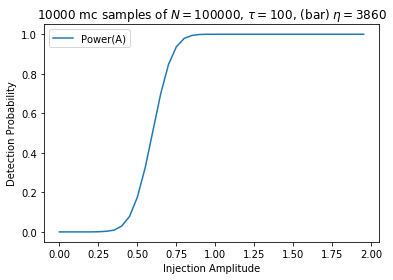

In [30]:
desired_pwr = 0.5
# again, let's run on cluster and import data from files
N = 10**5
bar = 3860
Nmc = 10**4
plot_amps = np.genfromtxt('amps_pwrA_10k5.csv', delimiter=',') #Avals
plot_pwrs = np.genfromtxt('pwrA_10k5.csv', delimiter=',') #counts
# we find that for P(A > 1) = 1, which makes sense b/c leading order is A^2
namps = np.size(plot_amps)
plot_amps = plot_amps[:namps//2]
plot_pwrs = plot_pwrs[:namps//2]
# interpolate Pi(A) and find zero of Pi(A) - desired_pwr
amp_for_desired_pwr = spline(plot_amps, plot_pwrs - desired_pwr).roots()
print('\nfor power = ', desired_pwr, '\nneed amplitude = ', amp_for_desired_pwr, '\n')
plt.figure(655)
plt.plot(plot_amps, plot_pwrs)
plt.legend(['Power(A)'])
plt.xlabel('Injection Amplitude')
plt.ylabel('Detection Probability')
plt.title(str(Nmc) + ' mc samples of $N=$' + str(N) + ', $\\tau=$' + str(tau) + \
          ', (bar) $\\eta=$' + str(bar))
plt.show(block=False)


for power =  0.5 
need amplitude =  [0.63280995] 



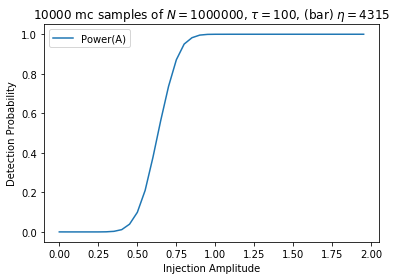

In [29]:
desired_pwr = 0.5
# and for N = 10^6
N = 10**6
bar = 4315
Nmc = 10**4
plot_amps = np.genfromtxt('amps_pwrA_10k6.csv', delimiter=',') #Avals
plot_pwrs = np.genfromtxt('pwrA_10k6.csv', delimiter=',') #counts
# we find that for P(A > 1) = 1
namps = np.size(plot_amps)
plot_amps = plot_amps[:namps//2]
plot_pwrs = plot_pwrs[:namps//2]
# interpolate Pi(A) and find zero of Pi(A) - desired_pwr
amp_for_desired_pwr = spline(plot_amps, plot_pwrs - desired_pwr).roots()
print('\nfor power = ', desired_pwr, '\nneed amplitude = ', amp_for_desired_pwr, '\n')
plt.figure(656)
plt.plot(plot_amps, plot_pwrs)
plt.legend(['Power(A)'])
plt.xlabel('Injection Amplitude')
plt.ylabel('Detection Probability')
plt.title(str(Nmc) + ' mc samples of $N=$' + str(N) + ', $\\tau=$' + str(tau) + \
          ', (bar) $\\eta=$' + str(bar))
plt.show(block=False)

********
g) $\textbf{What would you do if the size of the box is unknown,}$

$\textbf{and can take any width between 2 bins and 500 bins?}$

$\textbf{Use monte-carlo to set the bar. What is the equivalent look-elsewhere-effect?}$ 
********

if the width of the box $\tau$ is unknown, we can compute $z_{n_s}(\tau)$ for each $\tau \in [2, 500]$

then we must answer two questions: what is the new form of the hypothesis test? and how do we compute the relevant statistics?

to answer the first question, we must recognize the difference between scanning over ranges of $\tau$ and $n_s$: when we scan over $n_s$ we are looking for the same signal at different times, whereas when we scan over $\tau$ we are looking for qualitatively different signals

thus, it doesn't make sense to form the detection problem as a single hypothesis about the existence of some unspecified signal, but rather each value of $\tau$ should have its own hypothesis about the existence of a signal with that shape, which means that a different detection bar should be set for each value of $\tau$

this means that we are no longer looking for a scalar cutoff in a 1d space, but rather a curve $\eta(\tau)$ such that only a fraction $\alpha$ of the points lie above it, and there will be freedom in how we draw this curve -- in this simple case where we have no priors about pulse width, we can achieve this by using a single detection bar but computing a different test statistic for each width $\tau$: the normalized $ \frac{\lambda(\tau; x)}{\tau} = max_{n_s} \frac{|z(\tau, n_s; x)|^2}{\tau} $ 

as for the question of how to compute these test statistics efficiently, there is undoubtedly a way to leverage the fact that $z(\tau, n_s; x)$ at larger values of $\tau$ is the sum of statistics at smaller $\tau$ and different $n_s$, e.g., $ z(100, 0; x) = z(50, 0; x) + z(50, 50; x) $

in fact, we can construct $z(\tau, n_s; x)$ for $ \tau = 4, 5, ..., 500 $ using only $ \tau = 2, 3 $ but for the sake of simplicity we will take the brute force approach

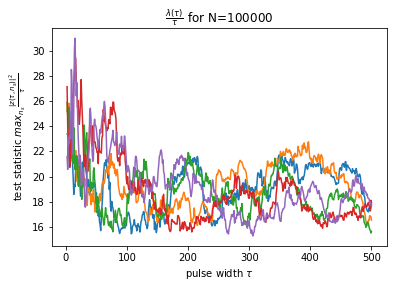

In [14]:
# let's just see what lambda / tau looks like as a function of tau for a few samples
N = 10**5
taus = np.arange(2, 501)
Nt = np.size(taus)
alpha = 0.0001
nsamples = 5#10 / alpha:
ft_signals = np.empty((Nt, N), dtype=np.csingle)
for j, tt in enumerate(taus):
    ft_signals[j] = np.fft.fft(np.concatenate([np.zeros(N-tt), np.ones(tt)]))
max_tau_stats = np.empty(nsamples)
tau_stats = np.empty(Nt)
plt.figure(987)
plt.title('$\\frac{\lambda(\\tau)}{\\tau}$ for N=' + str(N))
plt.xlabel('pulse width $\\tau$')
plt.ylabel('test statistic $max_{n_s} \\frac{|z(\\tau, n_s)|^2}{\\tau}$')
for i in np.arange(nsamples):
    ft_noise = np.fft.fft(np.random.normal(0, 1, N) + \
                          1j*np.random.normal(0, 1, N))
    for j in np.arange(Nt):
        tau_stats[j] = max(abs2(np.fft.ifft(ft_signals[j] * ft_noise))) / float(taus[j])
    max_tau_stats[i] = max(tau_stats)
    plt.plot(taus, tau_stats)
plt.show(block=False)

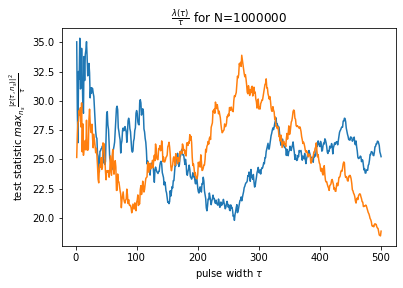

In [15]:
# and again for the dreaded N = 10^6
N = 10**6
taus = np.arange(2, 501)
Nt = np.size(taus)
alpha = 0.0001
nsamples = 2#10 / alpha:
ft_signals = np.empty((Nt, N), dtype=np.csingle)
for j, tt in enumerate(taus):
    ft_signals[j] = np.fft.fft(np.concatenate([np.zeros(N-tt), np.ones(tt)]))
max_tau_stats = np.empty(nsamples)
tau_stats = np.empty(Nt)
plt.figure(989)
plt.title('$\\frac{\lambda(\\tau)}{\\tau}$ for N=' + str(N))
plt.xlabel('pulse width $\\tau$')
plt.ylabel('test statistic $max_{n_s} \\frac{|z(\\tau, n_s)|^2}{\\tau}$')
for i in np.arange(nsamples):
    ft_noise = np.fft.fft(np.random.normal(0, 1, N) + \
                          1j*np.random.normal(0, 1, N))
    for j in np.arange(Nt):
        tau_stats[j] = max(abs2(np.fft.ifft(ft_signals[j] * ft_noise))) / float(taus[j])
    max_tau_stats[i] = max(tau_stats)
    plt.plot(taus, tau_stats)
plt.show(block=False)

In [2]:
# plot histogram of monte carlo samples 
def mc_hist_alltau(stats, N=1000000, alpha=0.0001, nsamples=100000):
    plt.hist(stats, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
    plt.xlabel('$max_{n_s, \\tau} \\frac{|z_0|^2}{\\tau}$')
    plt.ylabel('count')
    plt.title(str(nsamples) + ' MC samples with $N=$' + str(N) + \
              ', $2 \\leq \\tau \\leq 500$, $\\alpha=$' + str(alpha))
    plt.show(block=False)
    return

# get monte carlo samples of test statistics from file and analyze
def get_stats_file_alltau(filename, N=1000000, alpha=0.0001):
    taustats = np.genfromtxt(filename, delimiter=',')
    bartau = np.quantile(taustats, 1 - alpha)
    alphatau = np.exp(-bartau / 2.0)
    lef_Ntau = alphatau / alpha
    Nmc = np.size(taustats)
    print(str(Nmc), ' samples of N=', str(N), ', alpha=', \
          str(alpha), '\n[bar, alpha_prime, lef_N] = \n', [bartau, alphatau, lef_Ntau])
    mc_hist_alltau(taustats, N=N, alpha=alpha, nsamples=Nmc)
    return taustats

100000  samples of N= 100000 , alpha= 0.0001 
[bar, alpha_prime, lef_N] = 
 [47.117469083945274, 5.869101061444592e-11, 5.869101061444592e-07]


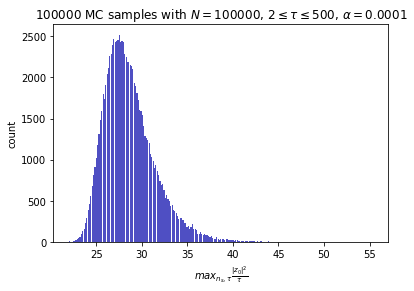

In [9]:
# now this data is surely too much for a laptop on reasonable time scale
taustats5 = get_stats_file_alltau('max10e5t2_500stats_100k.csv', N=100000, alpha=0.0001)

100000  samples of N= 1000000 , alpha= 0.0001 
[bar, alpha_prime, lef_N] = 
 [50.52750074834001, 1.0668236143474414e-11, 1.0668236143474413e-07]


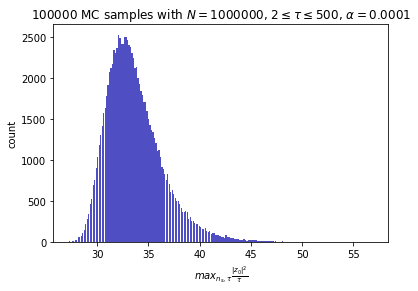

In [10]:
# this data takes > 1 day on cluster even when done in parallel batches of 1000 samples
taustats6 = get_stats_file_alltau('max10e6t2_500stats_100k.csv', N=1000000, alpha=0.0001)

so it seems that searching all $499$ values of $\tau$ increases the effective number of independent samples by factors of roughly $100$ for $N = 10^5$ and $50$ for $N = 10^6$ 

********
2) You are looking for the same box as in (1), but suppose that the noise is of the following form:
n(t) = np.random.normal(0,1,$10^6$) convolved with a normalized triangular shape of width 500 [normalized such that np.linalg.norm(triangle)=1].
********

In [3]:
# these jit wrappers do seems to shave a bit of computation time
@jit(nopython=True)
def Mv(mat, vec):
    return mat.dot(vec)

@jit(nopython=True)
def vdot(vec1, vec2):
    return np.dot(vec1,vec2)

@jit(nopython=True)
def Minv(mat):
    if np.linalg.matrix_rank(mat) < (mat[0]).size:
        print('ERROR: matrix is singular')
        return None
    else:
        return np.linalg.inv(mat)

# using moore-penrose inverse handles singular convolution matrix problem
@jit(nopython=True)
def Mpinv(mat):
    return np.linalg.pinv(mat)    

@jit(nopython=True)
def Mtrans(mat):
    return np.transpose(mat)

@jit(nopython=True)
def unitv(vec):
    return vec / np.linalg.norm(vec)

# "upright right triangle" (also isosceles, with equal sides making L-shape) -->
# right angle b/w base and left side (I think this is called "sawtooth" pulse)
@jit(nopython=True)
def get_tri_right(arr_size, tri_width, start=0):
    tri_r = np.zeros(arr_size)
    for j in np.arange(start, start + tri_width):
        tri_r[j] = tri_width - j
    return tri_r / np.linalg.norm(tri_r)

# "upright isosceles triangle" (also a right triangle, with hypotenuse as base)
# right angle b/w left and right sides (this one is definitely called "triangular")
@jit(nopython=True)
def get_tri_iso(arr_size, tri_width, start=0):
    tri_i = np.zeros(arr_size)
    iso_height = int(tri_width / 2)
    tri_i[start + iso_height] = iso_height
    for j in np.arange(start, start + iso_height):
        tri_i[iso_height - j] = iso_height - j
        tri_i[iso_height + j] = iso_height - j
    return tri_i / np.linalg.norm(tri_i)

# get WGN
@jit(nopython=True)
def get_wgn(arr_size):
    return np.random.normal(0,1,arr_size) + 1j*np.random.normal(0,1,arr_size)

# get real WGN
@jit(nopython=True)
def real_wgn(arr_size):
    return np.random.normal(0,1,arr_size)

# get unit height rectangular pulse signal
@jit(nopython=True)
def get_signal(arr_size, sig_width, start=0):
    over = arr_size - sig_width - start
    if over < 0:
        return np.concatenate((np.ones(-over), np.zeros(arr_size - sig_width), \
                               np.ones(sig_width + over)))
    else:
        return np.concatenate((np.zeros(start), np.ones(sig_width), np.zeros(over)))

# get \hat{s}_{n_s - n --> n} to be used in fft computation of z(n_s)
@jit(nopython=True)
def get_revsig(arr_size, sig_width):
    return np.concatenate((np.ones(1), np.zeros(arr_size - sig_width), \
                           np.ones(sig_width - 1)))

def get_revsig_ft(arr_size, sig_width):
    return np.fft.fft(get_revsig(arr_size, sig_width))

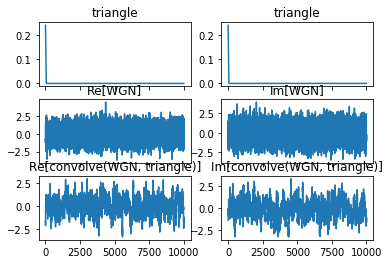

In [36]:
# let's see what this convolved noise looks like
N = 10**4
triangle_width = 50
tri = get_tri_right(N, triangle_width)
old_noise = get_wgn(N) #np.random.normal(0, 1, N)
new_noise = np.fft.ifft(np.fft.fft(tri) * np.fft.fft(old_noise))
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True)
ax[0][0].set_title('triangle')
ax[0][0].plot(np.arange(N), tri)
ax[0][1].set_title('triangle')
ax[0][1].plot(np.arange(N), tri)
ax[1][0].set_title('Re[WGN]')
ax[1][0].plot(np.arange(N), old_noise.real)
ax[1][1].set_title('Im[WGN]')
ax[1][1].plot(np.arange(N), old_noise.imag)
ax[2][0].set_title('Re[convolve(WGN, triangle)]')
ax[2][0].plot(np.arange(N), new_noise.real)
ax[2][1].set_title('Im[convolve(WGN, triangle)]')
ax[2][1].plot(np.arange(N), new_noise.imag)
plt.show(block=False)

********
a) $\textbf{Write a statistical model for the null (H0) and the alternative hypothesis (H1) in real space}$

$\textbf{what is the Neyman-Pearson detection statistic you would compute? [use matrix notation]}$
********

note that it may get confusing which variables refer to which objects, and as such it may not be immediately clear from a single form of an expression whether things are real- or complex-valued and whether things are scalars or vectors (which gets especially confusing for expressions like $|v|$), so to minimize the necessity of checking back with the definitions I will try to write expressions in multiple forms and explicitly go through computational steps

in general, keep in mind that $v_n$ is a component of vector $v$ and $ u^T v = u \cdot v = \sum_n u_n v_n = v^T u $, while $ |v|^2 = \langle v, v \rangle = v^{\dagger} v = \sum_n v_n^{*} v_n = \sum_n |v_n|^2 $, where $ v^{\dagger} = (v^{*})^T $ is the conjugate-transpose (equivalently adjoint or hermitian conjugate)

we have a time series of $ N $ complex data points $ x_n, n = 0, 1, ..., N-1 $ 

the null hypothesis is that the data is complex white gaussian noise (WGN) $ w_n \sim CN(0,2) \implies \Re(w_n), \Im(w_n) \sim N(0,1) $ convolved with a normalized triangular pulse $t_n(\tau_{tri})$ of base width $\tau_{tri}$, giving the noise vector

$ n_n(\tau_{tri}) = w_n * t_n(\tau_{tri}) = \sum_{n'} w_{n'} t_{n - n'}(\tau_{tri}) = F^{-1}[F[w_n]_k F[t_n(\tau_{tri})]_k]_n $

using the matrix notation $ T_{n \, n'} \equiv t_{n - n'}(\tau_{tri}) $, we can write the noise as

$ n_n = \sum_{n'} T_{n \, n'} w_n \equiv (T w)_n $

the alternative hypothesis is that, in addition to this noise, the data contains a rectangular pulse of complex height $ A e^{i \phi} $ and length $\tau$ starting at time $n_s$ (signal): 

$ s_n = A e^{i \phi} Indicator[n_s \leq n < n_s + \tau]_n \equiv A e^{i \phi} \hat{s}_n(\tau, n_s) $

we first write these hypotheses as

$ H_0: x_n = n_n(\tau_{tri}) = (T w)_n $

$ H_1(A, \phi, \tau, n_s, \tau_{tri}): x_n = n_n(\tau_{tri}) + s_n(\tau, n_s) = (T w)_n + A e^{i \phi} \hat{s}_n $

and to compute the likelihoods $ L[H|x] = P[x|H] = P[H|x] \frac{P[x]}{P[H]} $ we rewrite this as 

$ H_0: w_n = (T^{-1} x)_n $

$ H_1(A, \phi, \tau, n_s, \tau_{tri}): w_n = (T^{-1} x)_n - A e^{i \phi} (T^{-1} \hat{s}(\tau, n_s))_n $

so that we can use the circularly symmetric complex gaussian probability to get

$ P[x|H_0] = (2 \pi)^{-\frac{N}{2}} e^{-\frac{1}{2} (T^{-1} x)^{\dagger} T^{-1} x} $

$ P[x|H_1(A, \tau, n_s, \tau_{tri})] = (2 \pi)^{-\frac{N}{2}} e^{-\frac{1}{2} (T^{-1} x - T^{-1} s)^{\dagger} (T^{-1} x + T^{-1} s)} $

then, noting that $ t(\tau_{tri}), T(\tau_{tri}), T^{-1}(\tau_{tri}), \hat{s}(\tau, n_s) $ are all real-valued, so their transposes and adjoints are equivalent, and defining the deconvolution matrix 

$ D(\tau_{tri}) \equiv T^{-1} \in \mathbb{R}^{N x N} $, taken in general to be the moore-penrose pseudoinverse, and

$ M(\tau_{tri}) \equiv D^{\dagger} D = D^T D = (T^{-1})^{T} T^{-1} = (T^{-1})^{\dagger} T^{-1} = M^{\dagger} = M^T \in \mathbb{R}^{N x N} $, and 

$ s_{tri}(\tau, n_s, \tau_{tri}) \equiv D \hat{s} = T^{-1} \hat{s} \in \mathbb{R}^N $, and 

$ \sigma(\tau_{tri}) \equiv D^{\dagger} s_{tri} = D^T s_{tri} = M \hat{s} = (T^{-1})^{T} T^{-1} \hat{s} \in \mathbb{R}^N $

we get

$ \Lambda(A, \phi, \tau, n_s, \tau_{tri}; x) \equiv \frac{P[x|H_1]}{P[x|H_0]} = e^{-\frac{1}{2} (|D x - A e^{i \phi} D \hat{s}|^2 - |D x|^2)} = e^{-\frac{1}{2} (A^2 \hat{s}^T M \hat{s} - A e^{-i \phi} \hat{s}^T M x - A e^{i \phi} x^{\dagger} M \hat{s})} $

$ = e^{-\frac{1}{2} (A^2 |s_{tri}|^2 - A \sigma^T (e^{-i \phi} x) - A (e^{i \phi} x^{*})^T \sigma)} = e^{-\frac{1}{2} A^2 |s_{tri}|^2} e^{\frac{1}{2} - A \sigma \cdot (e^{-i \phi} x + e^{i \phi} x^{*})}= e^{-\frac{A^2 |s_{tri}|^2}{2}} e^{A \sigma \cdot \Re(e^{-i \phi} x)} $

then we define

$ z(\tau, n_s, \tau_{tri}; x) \equiv \sigma^{\dagger} x = \sum_n \sigma_n^{*} x_n = \sum_n \sigma_n x_n = \sigma^T x = \sigma \cdot x = s_{tri}^T D x$

and we see that $ \sigma \cdot \Re(e^{-i \phi} x) = \Re(e^{-i \phi} \sigma \cdot x) = \Re(e^{-i \phi} z) = |z| \cos(\arg(z) - \phi) $

so, just as in problem 1, we can marginalize over $\phi$ to get

$ \Lambda(A, \tau, n_s, \tau_{tri}; x) = \int_0^{2 \pi} \frac{d\phi}{2 \pi} \Lambda(A, \phi, \tau, n_s, \tau_{tri}; x) = e^{-\frac{A^2 |s_{tri}|^2}{2}} I_0(A |z(\tau, n_s, \tau_{tri}; x)|) $

from which we get the neyman-pearson test statistic

$ \lambda(\tau, n_s, \tau_{tri}; x) \equiv \frac{1}{A^2}(\ln(\frac{e^{A^2 |z|^2}}{I_0(A |z|)} \Lambda(A, \tau, n_s, \tau_{tri}; x)) + \frac{A^2 |s_{tri}|^2}{2}) = |z(\tau, n_s, \tau_{tri}; x)|^2 $

then we reject $H_0$ in favor of $H_1$ when

$ \lambda(\tau, n_s, \tau_{tri}; x) = |z|^2 = |\sigma \cdot x|^2 = |s_{tri}^T D x|^2 = |\hat{s}^T M x|^2 > \eta_{\lambda}(\alpha) $

where the threshold (detection bar) $\eta_{\lambda}(\alpha)$ is set by the requirement that

$ P[\lambda(\tau, n_s, \tau_{tri}; x) > \eta_{\lambda} | H_0] = P[\lambda(\tau, n_s, \tau_{tri}; x = T w = D^{-1} w) > \eta_{\lambda}] = $

$ P[|s_{tri}^T D D^{-1} w|^2 > \eta_{\lambda}] = P[|s_{tri}(\tau, n_s, \tau_{tri}) \cdot w|^2 > \eta_{\lambda}(\alpha)] = \alpha $

for our desired significance level (false detection rate) $\alpha$

then we note that $ (s_{tri})_n w_n $ is a complex gaussian with variance $ 2 (s_{tri})_n^2 $, so $ s_{tri}(\tau, n_s, \tau_{tri}) \cdot w $ is a complex gaussian with variance $ 2 |s_{tri}|^2 $ and $ \frac{s_{tri}^T}{|s_{tri}|} w \sim CN(0,2) \implies |\frac{s_{tri}^T}{|s_{tri}|} w|^2 \sim \chi^2(2) $, giving

$ P[\frac{\lambda(\tau, n_s, \tau_{tri}; x)}{|s_{tri}|^2} > \frac{\eta_{\lambda}}{|s_{tri}|^2} | H_0] = P[\chi^2(2) > \frac{\eta_{\lambda}}{|s_{tri}|^2}] = 1 - F_{\chi^2(2)}(\frac{\eta_{\lambda}(\alpha)}{|s_{tri}|^2}) = e^{-\frac{\eta_{\lambda}(\alpha)}{2 |s_{tri}|^2}} = \alpha $

$ \implies \frac{\eta_{\lambda}(\alpha)}{|s_{tri}|^2} = F_{\chi^2(2)}^{-1}(1 - \alpha) = -2 \ln(\alpha) $

where we have used $ F_{\chi^2(2)}(y) = 1 - e^{-\frac{y}{2}} $ and $ F_{\chi^2(2)}^{-1}(p) = -2 \ln(1 - p) $

so

$ \frac{\eta_{\lambda}(\alpha = 10^{-4})}{|s_{tri}|^2} = 8 \ln(10) = 18.4207 $

In [4]:
# get circular convolution matrix T (consistent w/fft)
# thus T_{i j} = vec[i - j] (with negative indices as interpreted by python giving
# the correct mod N boundary wrapping behavior of circular convolution)
@jit(nopython=True)
def get_tmat(vec):
    arr_size = vec.size
    mat = np.empty((arr_size, arr_size))
    mat[:,0] = vec
    for j in np.arange(1, arr_size):
        mat[:j,j] = vec[-j:]
        mat[j:,j] = vec[:arr_size-j]
    return mat

# this gives M = (T^{-1})^{T} T^{-1}
# using np.matmul (no numba support) faster than jit with np.dot
def get_mmat(vec):
    mat = Mpinv(get_tmat(vec))
    return np.matmul(np.transpose(mat), mat)

# get M.sigvec = (T^{-1})^{T} T^{-1} sigvec
@jit(nopython=True)
def get_time_svec(trivec, sigvec):
    mat = np.linalg.pinv(get_tmat(trivec))
    return (np.transpose(mat)).dot(mat.dot(sigvec))

# get F[sigvec]_k / |F[trivec]_k|^2 = F[M.sigvec]_k
def get_freq_svec(trivec, sigvec):
    return np.fft.fft(sigvec) / abs2(np.fft.fft(trivec))

# get D.sigvec = T^{-1} sigvec
@jit(nopython=True)
def get_time_stri(trivec, sigvec):
    return (np.linalg.pinv(get_tmat(trivec))).dot(sigvec)

# get F[sigvec]_k / F[trivec]_k = F[D.sigvec]_k
def get_freq_stri(trivec, sigvec):
    return np.fft.fft(sigvec) / np.fft.fft(trivec)

# get simulated signal in real space
@jit(nopython=True)
def simulate_signal(arr_size, sig_width, start=0, amp=1.0, phi=0.0):
    return amp * np.exp(1j*phi) * get_signal(arr_size, sig_width, start=start)

********
b) $\textbf{Write a statistical model for the null (H0) and the alternative hypothesis (H1)  in Fourier space. }$

$\textbf{what is the Neyman-Pearson detection statistic you would compute? }$

$\textbf{Is it the same statistic? Simulate a signal and compute the score in several positions, }$

$\textbf{in real space and Fourier space, make sure you get the same number to machine precision.}$
********

now letting $ \tilde{v}_k \equiv F[v_n]_k $, we have the fourier space hypotheses

$ H_0: \tilde{x}_k = \tilde{n}_k = \tilde{t}(\tau_{tri})_k \tilde{w}_k $

$ H_1(A, \phi, \tau, n_s, \tau_{tri}): \tilde{x}_k = \tilde{n}_k + \tilde{s}_k = \tilde{t}(\tau_{tri})_k \tilde{w}_k + A e^{i \phi} \tilde{\hat{s}}_k(\tau, n_s) $

and since circularly symmetric $ w_n \sim CN(0,2) $ we also have $ \tilde{w}_k \sim CN(0,2) $, or $ \frac{\tilde{w}_k}{\sqrt{N}} \sim CN(0,2) $ depending on the fourier transform normalization (but this can be dealt with later), so we can again use the complex gaussian probability with the hypotheses rewritten as 

$ H_0: \tilde{w}_k = \frac{\tilde{x}_k}{\tilde{t}_k} $

$ H_1(A, \phi, \tau, n_s, \tau_{tri}): \tilde{w}_k = \frac{\tilde{x}_k - \tilde{s}_k}{\tilde{t}_k} $

to get

$ \Lambda(A, \phi, \tau, n_s, \tau_{tri}; \tilde{x}) \equiv \frac{P[\tilde{x}|H_1]}{P[\tilde{x}|H_0]} = e^{-\frac{1}{2} \sum_k (|\frac{\tilde{x}_k - \tilde{s}_k}{\tilde{t}_k}|^2 - |\frac{\tilde{x}_k}{\tilde{t}_k}|^2)} = e^{-\frac{1}{2} \sum_k (A^2 |\frac{\tilde{\hat{s}}_k}{\tilde{t}_k}|^2 - \frac{A}{|\tilde{t}_k|^2} (e^{-i \phi} \tilde{\hat{s}}_k^{*} \tilde{x}_k + e^{i \phi} \tilde{x}_k^{*} \tilde{\hat{s}}_k))} $

$ = e^{-\frac{A^2}{2} \sum_k |\frac{\tilde{\hat{s}}_k}{\tilde{t}_k}|^2} e^{A \sum_k \frac{\Re(e^{-i \phi} \tilde{\hat{s}}_k^{*} \tilde{x}_k)}{|\tilde{t}_k|^2}} = e^{-\frac{A^2}{2} |\tilde{s}_{tri}|^2} e^{A \Re(e^{-i \phi} \sum_k \frac{\tilde{\hat{s}}_k^{*} \tilde{x}_k}{|\tilde{t}_k|^2})} $

where $ \tilde{s}_{tri}(\tau, n_s, \tau_{tri})_k \equiv \frac{\tilde{\hat{s}}_k}{\tilde{t}_k} = F[s_{tri}]_k $ is the fourier transform of $ s_{tri}(\tau, n_s, \tau_{tri}) = D \hat{s} $ from above

and then we define the fourier space statistic

$ \tilde{z}(\tau, n_s, \tau_{tri}; \tilde{x}) \equiv \sum_k \frac{\tilde{\hat{s}}_k^{*} \tilde{x}_k}{|\tilde{t}_k|^2} = \sum_k \tilde{\sigma}_k^{*} \tilde{x}_k = \tilde{\sigma}^{\dagger} \tilde{x} $

where $ \tilde{\sigma}(\tau, n_s, \tau_{tri})_k \equiv \frac{\tilde{\hat{s}}_k}{|\tilde{t}_k|^2} = F[\sigma]_k $ is the fourier transform of $ \sigma(\tau, n_s, \tau_{tri}) = M \hat{s} $ from above

and as in real space we have $ \Re(e^{-i \phi} \tilde{z}(\tau, n_s, \tau_{tri}; \tilde{x})) = |\tilde{z}| \cos(\arg(\tilde{z}) - \phi) $, so again we marginalize over $\phi$ to get 

$ \Lambda(A, \tau, n_s, \tau_{tri}; \tilde{x}) = e^{-\frac{A^2 |\tilde{s}_{tri}|^2}{2}} I_0(A |\tilde{z}(\tau, n_s, \tau_{tri}; \tilde{x})|) $

from which we get the neyman-pearson test statistic

$ \lambda(\tau, n_s, \tau_{tri}; \tilde{x}) \equiv \frac{1}{A^2}(\ln(\frac{e^{A^2 |\tilde{z}|^2}}{I_0(A |\tilde{z}|)} \Lambda(A, \tau, n_s, \tau_{tri}; \tilde{x})) + \frac{A^2 |\tilde{s}_{tri}|^2}{2}) = |\tilde{z}(\tau, n_s, \tau_{tri}; \tilde{x})|^2 $

then we reject $H_0$ in favor of $H_1$ when

$ \lambda(\tau, n_s, \tau_{tri}; \tilde{x}) = |\tilde{z}|^2 = |\sum_k \tilde{\sigma}_k^{*} \cdot \tilde{x}_k|^2 = |\tilde{\sigma}^{\dagger} \tilde{x}|^2 > \tilde{\eta}_{\lambda}(\alpha) $

and we notice that parseval's theorem tells us that

$ \frac{\tilde{z}(\tau, n_s, \tau_{tri}; \tilde{x})}{N} = \frac{1}{N} \sum_k \tilde{\sigma}_k^{*} \cdot \tilde{x}_k = \sum_n \sigma_n^{*} x_n = z(\tau, n_s, \tau_{tri}; x) $

so the test statistics in real space and fourier space are the same after normalization, giving

$ \frac{\lambda(\tau, n_s, \tau_{tri}; \tilde{x})}{N^2} = |\frac{\tilde{z}}{N}|^2 = |z|^2 = \lambda(\tau, n_s, \tau_{tri}; \tilde{x}) $

and therefore

$ \tilde{\eta}_{\lambda}(\alpha) = N^2 \eta_{\lambda}(\alpha) $

In [6]:
# check circular convolution theorem consistency under null hypothesis
nn = 1000
tau = 10
tautri = 50
ss = get_signal(nn,tau)
tt = get_tri_right(nn,tautri)
ww = get_wgn(nn)
stri = get_time_stri(tt, ss)
ss_ft = np.fft.fft(ss)
tt_ft = np.fft.fft(tt)
ww_ft = np.fft.fft(ww)
stri = get_time_stri(tt, ss)
stri_til = get_freq_stri(tt, ss)
x = (get_tmat(tt)).dot(ww)
x_ft = np.fft.fft(tt)*np.fft.fft(ww)
print('circular convolution check: ', np.allclose(x, np.fft.ifft(x_ft)))
# use plancherel theorem to verify fft normalization
print('\ncheck normalization sum_n |x_n|^2 = (1/N) sum_k |tilde{x}_k|^2: ',\
      np.isclose(np.sum(abs2(x)), np.sum(abs2(x_ft))/nn))
# check parseval's theorem consistency under H_0
sigma = get_time_svec(tt, ss)
sigma_til = get_freq_svec(tt,ss)
# and make sure stri_til=F[sig]/F[t] and sigma_til=F[sig]/|F[t]|^2 really are 
# ffts of stri=T^{-1}.sig and sigma=(T^{-1})^{T}.(T^{-1}.sig)
print('\ncheck [sigma_til = F[sigma], s_tri_til = F[s_tri]]:', \
      [np.allclose(sigma_til, np.fft.fft(sigma)), \
       np.allclose(stri_til, np.fft.fft(stri))])
time_ans0 = np.sum(x*sigma)
freq_ans0 = np.sum(x_ft*np.conj(sigma_til))/nn
print('\nparseval check (same stat in real and fourier space): ', \
      np.isclose(time_ans0,freq_ans0))
# check that using Tw and sigma equivalent to using w and stri
print('\nsigma* . Tw = s_tri* . w in [real, fourier]: ', \
      np.isclose(np.array([time_ans0, freq_ans0]), \
                 np.array([np.sum(ww*stri), np.sum(ww_ft*np.conj(stri_til))/nn])))
# and finally, check that we can still get z0 for all n_s by exploting convolution
# theorem, writing z(n_s) = sigma . x = signal . Mx = F^{-1}[F[revsig] F[Mx]]
mmat_x = (get_mmat(tt)).dot(x)
zall = np.fft.ifft(np.fft.fft(get_revsig(nn,tau)) * np.fft.fft(mmat_x))
ns_vals = np.random.randint(0, nn, size=3)
zall_vals = zall[np.concatenate((np.array([0]), ns_vals))]
zns_vals = [time_ans0]
for ns in ns_vals:
    zns_vals.append(np.sum(get_signal(nn,tau,start=ns) * mmat_x))
print('\nz(n_s) = sigma . x = signal . Mx = F^{-1}[F[revsig] F[Mx]]: ', \
      np.allclose(zall_vals, np.array(zns_vals)))

circular convolution check:  True

check normalization sum_n |x_n|^2 = (1/N) sum_k |tilde{x}_k|^2:  True

check [sigma_til = F[sigma], s_tri_til = F[s_tri]]: [True, True]

parseval check (same stat in real and fourier space):  True

sigma* . Tw = s_tri* . w in [real, fourier]:  [ True  True]

z(n_s) = sigma . x = signal . Mx = F^{-1}[F[revsig] F[Mx]]:  True


numerical verification of the equivalence of test statistics under $H_0$ was done above, although the real space calculation cannot be completed for $N$ larger than roughly $10^4$ because beyond this point there will be memory overflow in computing the dense $N x N$ matrix $D$, without which we cannot compute $\sigma$ or $s_{tri}$ (of course, it could be computed without the deconvolution matrix using fft, but this would just be the fourier space version, which is what we want to compare with)

so, to check that the statistics agree under $H_1$ we will use $N = 10^4$

In [6]:
# check parseval's theorem consistency under H_1 for several positions
nn = 10000
tau = 10
tautri = 50
tt = get_tri_right(nn,tautri)
ww = get_wgn(nn)
tt_ft = np.fft.fft(tt)
ww_ft = np.fft.fft(ww)
noise = (get_tmat(tt)).dot(ww)
noise_ft = tt_ft * ww_ft
ns_vals = np.random.randint(0, nn, size=4)
phi = 2*np.pi*np.random.random()
amp = 3*np.random.random()
sim_sig = amp * np.exp(1j*phi) * get_signal(nn, tau, start=ns_vals[0])
sim_sig_ft = np.fft.fft(sim_sig)
x = noise + sim_sig
x_ft = noise_ft + sim_sig_ft
Mx = (get_mmat(tt)).dot(x)
Mx_ft = x_ft / abs2(tt_ft)
ztime = np.fft.ifft(np.fft.fft(get_revsig(nn,tau)) * np.fft.fft(Mx))
ztime_vals = ztime[ns_vals]
zfreq_vals = []
for ns in ns_vals:
    zfreq_vals.append(np.sum(Mx_ft * \
                             np.conj(np.fft.fft(get_signal(nn,tau,start=ns)))))
print('z(n_s) = tilde{z}(n_s) / N: ', \
      np.allclose(ztime_vals, np.array(zfreq_vals)/nn))

z(n_s) = tilde{z}(n_s) / N:  True


In [7]:
# and just make sure F[M x] = \tilde{x} / |\tilde{t}|^2 so that we can get z 
# for all n_s without ever having to compute M for the next parts
np.allclose(Mx_ft, np.fft.fft(Mx))

True

********
c) $\textbf{Are you more sensitive with this noise source, or in Q1?}$

$\textbf{What is the amplitude of the box such that if we "inject" a signal with this}$

$\textbf{amplitude, the detection probability is 0.5 [what about 0.1, 0.99, 0.9999]?}$
********

In [5]:
# to answer this, we first need to set the detection bar again using monte carlo
def get_H0stats(N=1000000, tau=100, tautri=500, nsamples=100000):
    # get \tilde{t}
    t_ft_cc = np.conj(np.fft.fft(get_tri_right(N, tautri)))
    # now under H_0, \tilde{x}_k = \tilde{t}_k * \tilde{w}_k
    # so F[Mx]_k = \tilde{t}_k * \tilde{w}_k / |\tilde{t}_k|^2 
    # = \tilde{w}_k / \tilde{t}_k^*
    ft_signal = np.fft.fft(np.concatenate((np.ones(1), np.zeros(N-tau), np.ones(tau-1))))
    stats = np.empty(nsamples)
    for i in np.arange(nsamples):
        stats[i] = max(abs2(np.fft.ifft(ft_signal * np.fft.fft(get_wgn(N)) / t_ft_cc)))
    return stats

# plot histogram of monte carlo samples 
def mc_H0hist(stats, N=1000000, tau=100, tautri=500, alpha=0.0001, nsamples=100000):
    plt.hist(stats, bins='auto', alpha=0.7, rwidth=0.85)
    plt.xlabel('max|z_0|^2')
    plt.ylabel('count')
    plt.title(str(nsamples) + ' MC samples with $N=$' + str(N) + ', $\\tau=$' + \
              str(tau) + ', $\\tau_{tri}=$' + str(tautri) + ', $\\alpha=$' + str(alpha))
    plt.show(block=False)
    return

# and to run this for 100k samples we will need to send it to a cluster
def get_H0stats_file(filename, N=1000000, tau=100, tautri=500, alpha=0.0001):
    s_tri = get_freq_stri(get_tri_right(N, tautri), get_signal(N, tau))
    stats = np.genfromtxt(filename, delimiter=',')
    bar = np.quantile(stats, 1 - alpha)
    alpha_prime = np.exp(-bar / float(2*np.sum(abs2(s_tri))/N))
    lef_N = alpha_prime / alpha
    Nmc = np.size(stats)
    print(str(Nmc), ' samples of N=', str(N), ', tau=', str(tau), ', tau_{tri}=', \
          str(tautri), ', alpha=', str(alpha), \
          '\n[bar, alpha_prime, lef_N] = \n', [bar, alpha_prime, lef_N])
    mc_H0hist(stats, N=N, tau=tau, tautri=tautri, alpha=alpha, nsamples=Nmc)
    return stats

def get_H0stats_alltau(N=1000000, tau_start=2, tau_end=500, tautri=500, nsamples=100000):
    t_ft = np.fft.fft(get_tri_right(N, tautri))
    taus = np.arange(tau_start, tau_end + 1)
    Nt = np.size(taus)
    ft_mults = np.empty((Nt, N), dtype=np.csingle)
    stnorms = np.empty(Nt)
    for j, tau in enumerate(taus):
        ft_revsig = np.fft.fft(np.concatenate((np.ones(1),np.zeros(N-tau),np.ones(tau-1))))
        stnorms[j] = np.sum(abs2(ft_revsig / t_ft)) / float(N)
        ft_mults[j] = ft_revsig / np.conj(t_ft)
    stats = np.empty(nsamples)
    taustats = np.empty(Nt)
    for i in np.arange(nsamples):
        w_ft =  np.fft.fft(np.random.normal(0, 1, N) + 1j*np.random.normal(0, 1, N))
        for j in np.arange(Nt):
            taustats[j] = np.max(abs2(np.fft.ifft(w_ft * ft_mults[j]))) / stnorms[j]
        stats[i] = np.max(taustats)
    return stats

# get monte carlo samples of test statistics from file and analyze
def get_H0stats_file_alltau(filename, N=1000000, tautri=500, alpha=0.0001):
    taustats = np.genfromtxt(filename, delimiter=',')
    bartau = np.quantile(taustats, 1 - alpha)
    alphatau = np.exp(-bartau / 2.0)
    lef_Ntau = alphatau / alpha
    Nmc = np.size(taustats)
    print(str(Nmc), ' samples of N=', str(N), ', tau_{tri}=', str(tautri), ', alpha=', \
          str(alpha), '\n[bar, alpha_prime, lef_N] = \n', [bartau, alphatau, lef_Ntau])
    plt.hist(taustats, bins='auto', alpha=0.7, rwidth=0.85)
    plt.xlabel('$max_{n_s, \\tau} |\\frac{z_0}{|s_{tri}|}|^2$')
    plt.ylabel('count')
    plt.title(str(Nmc) + ' MC samples with $N=$' + str(N) + ', $\\tau_{tri}=$' + \
              str(tautri) + ', $2 \\leq \\tau \\leq 500$, $\\alpha=$' + str(alpha))
    plt.show(block=False)
    return taustats

In [50]:
# let's check that it does the right thing
nn = 1000
tau = 10
tautri = 50
tt = get_tri_right(nn,tautri)
ww = get_wgn(nn)
tt_ft = np.fft.fft(tt)
ww_ft = np.fft.fft(ww)
noise = (get_tmat(tt)).dot(ww)
noise_ft = tt_ft * ww_ft
ft_revsig = np.fft.fft(get_revsig(nn,tau))
z_trust = np.fft.ifft(ft_revsig * noise_ft/abs2(tt_ft))
z_check = np.fft.ifft(ft_revsig * ww_ft/np.conj(tt_ft))
np.allclose(z_trust, z_check)

True

1000000  samples of N= 100000 , tau= 100 , tau_{tri}= 500 , alpha= 0.0001 
[bar, alpha_prime, lef_N] = 
 [13874.363848985888, 9.347378330095222e-10, 9.347378330095222e-06]


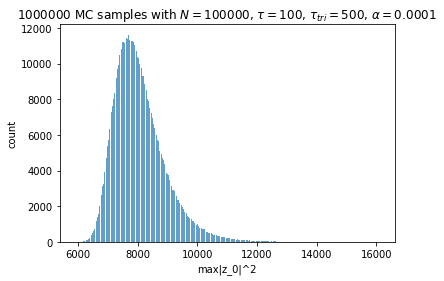

In [31]:
# now run on cluster
newstats5 = get_H0stats_file('max10e5t100tt500stats_1M.csv', N=100000, \
                             tau=100, tautri=500, alpha=0.0001)

1000000  samples of N= 1000000 , tau= 100 , tau_{tri}= 500 , alpha= 0.0001 
[bar, alpha_prime, lef_N] = 
 [15327.61371413725, 1.0590780980238297e-10, 1.0590780980238297e-06]


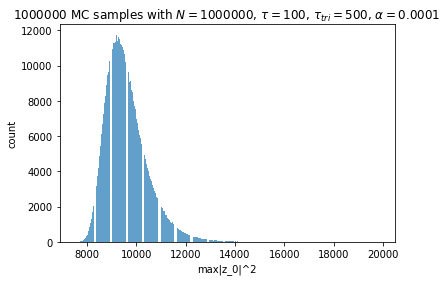

In [32]:
# and for N = 10^6
newstats6 = get_H0stats_file('max10e6t100tt500stats_1M.csv', N=1000000, \
                             tau=100, tautri=500, alpha=0.0001)

100000  samples of N= 100000 , tau_{tri}= 500 , alpha= 0.0001 
[bar, alpha_prime, lef_N] = 
 [53.505586342024834, 2.4066312424293883e-12, 2.4066312424293883e-08]


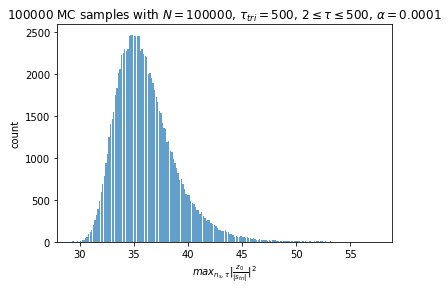

In [17]:
# or if we were to let tau run from 2 to 500 again:
newtaustats5 = get_H0stats_file_alltau('max10e5t2_500tt500stats_100k.csv', N=100000)

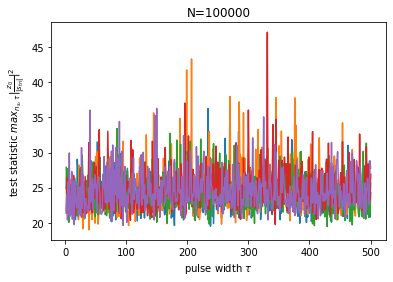

In [14]:
N = 10**5
t_ft = np.fft.fft(get_tri_right(N, tautri))
taus = np.arange(2, 501)
Nt = np.size(taus)
ft_mults = np.empty((Nt, N), dtype=np.csingle)
stnorms = np.empty(Nt)
nsamples = 5#10 / alpha:
ft_signals = np.empty((Nt, N), dtype=np.csingle)
for j, tau in enumerate(taus):
    ft_revsig = np.fft.fft(np.concatenate((np.ones(1),np.zeros(N-tau),np.ones(tau-1))))
    stnorms[j] = np.sum(abs2(ft_revsig / t_ft)) / float(N)
    ft_mults[j] = ft_revsig / np.conj(t_ft)
taustats = np.empty(Nt)
plt.figure(989)
plt.title('N=' + str(N))
plt.xlabel('pulse width $\\tau$')
plt.ylabel('test statistic $max_{n_s, \\tau} |\\frac{z_0}{|s_{tri}|}|^2$')
for i in np.arange(nsamples):
    w_ft =  np.fft.fft(np.random.normal(0, 1, N) + 1j*np.random.normal(0, 1, N))
    for j in np.arange(Nt):
        taustats[j] = np.max(abs2(np.fft.ifft(w_ft * ft_mults[j]))) / stnorms[j]
    plt.plot(taus, taustats)
plt.show(block=False)

100000  samples of N= 100000 , tau_{tri}= 500 , alpha= 0.0001 
[bar, alpha_prime, lef_N] = 
 [58.37020194967975, 2.113837960996192e-13, 2.113837960996192e-09]


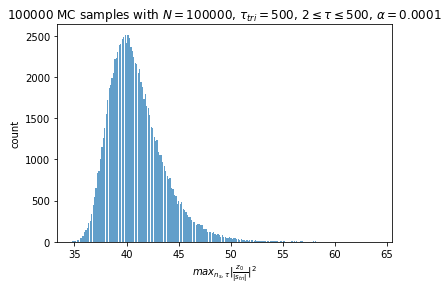

In [18]:
# and again for the dreaded N = 10^6
newtaustats6 = get_H0stats_file_alltau('max10e6t2_500tt500stats_100k.csv', N=100000)

NOTE that in this case of convolved noise, it appears that the effective number of independent samples is indeed the number of possible start times multiplied by the number of templates (signal widths), as opposed to the case of pure WGN where the effective number of independent samples was reduced by a fator of roughly 100

In [16]:
# now to find Power(A)
N = 10**5
tau = 100
tautri = 500
alpha = 10**(-4)
# results obtained above: (only searching with one template, so take bar for single tau)
bar5 = 13874.4
bar6 = 15327.6
# choose what bar to use
threshold = bar5
# set monte carlo parameters
Nmc = 1000
Amax = 4.0
Amin = 0.05
Avals = np.arange(Amin, Amax + Amin, Amin)
namps = np.size(Avals)
counts = np.zeros(namps)
# construct signal template for z0 convolution
srev_ft = np.fft.fft(get_resig(N,tau))
tt_ft = np.fft.fft(get_tri_right(N, tautri))
tt_ft_cc = np.conj(tt_ft)
# get z_inc(n_s) = Amin \hat{s}(\tau, n_s) M(\tau_{tri}) \hat{s}(\tau_I, n_sI)
nsI = int(N / 2) # and letting tau_I = tau, phi_I = 0
zinc = Amin * np.fft.ifft(srev_ft * np.fft.fft(get_signal(N,tau,start=nsI)) \
                          / abs2(tt_ft))
# now iterate over noise realizations
for i in range(Nmc):
    # compute pure noise component of z
    z0 = np.fft.ifft(srev_ft * np.fft.fft(get_wgn(N)) / tt_ft_cc)
    Aind = 0
    # compute bar array for efficient testing
    bar_im_z0sq = threshold - (z0.imag)**2
    # compute real part of z with with Amin
    re_z = z0.real + zinc
    while (np.sum(re_z**2 > bar_im_z0sq) == 0) and (Aind < namps):
        # increment real part of z until first amp that passes bar
        Aind += 1
        re_z += zinc
    # increment counts of all amps that pass bar
    counts += np.concatenate([np.zeros(Aind), np.ones(namps - Aind)])
# add A = 0 and Pi(A=0) = alpha to arrays, and make counts a probability array    
counts = np.concatenate([np.full(1, alpha), counts / float(Nmc)])
Avals = np.concatenate([np.zeros(1), Avals])
# save Pi(A) data from discretized interval
np.savetxt('pwrA2.csv', counts, delimiter=',')
np.savetxt('amps_pwrA2.csv', Avals, delimiter=',')

but let's run them on the cluster to obtain better statistics


for power =  0.5 
need amplitude =  [0.34890153] 



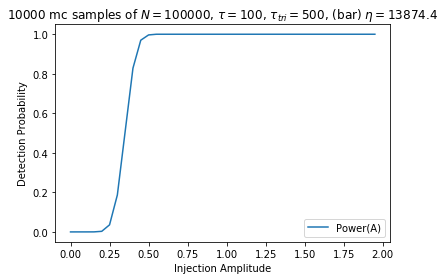

In [28]:
desired_pwr = 0.5
# already set above:
N = 10**5
tau = 100
tautri = 500
alpha = 10**(-4)
bar = 13874.4
Nmc = 10**4
plot_amps = np.genfromtxt('amps_pwrA2_10k5.csv', delimiter=',') #Avals
plot_pwrs = np.genfromtxt('pwrA2_10k5.csv', delimiter=',') #counts
# we find that for P(A > 1) = 1
namps = np.size(plot_amps)
plot_amps = plot_amps[:namps//2]
plot_pwrs = plot_pwrs[:namps//2]
# interpolate Pi(A) and find zero of Pi(A) - desired_pwr
amp_for_desired_pwr = spline(plot_amps, plot_pwrs - desired_pwr).roots()
print('\nfor power = ', desired_pwr, '\nneed amplitude = ', amp_for_desired_pwr, '\n')
plt.figure(656)
plt.plot(plot_amps, plot_pwrs)
plt.legend(['Power(A)'])
plt.xlabel('Injection Amplitude')
plt.ylabel('Detection Probability')
plt.title(str(Nmc) + ' mc samples of $N=$' + str(N) + ', $\\tau=$' + str(tau) + \
          ', $\\tau_{tri}=$' + str(tautri) + ', (bar) $\\eta=$' + str(bar))
plt.show(block=False)


for power =  0.5 
need amplitude =  [0.3675025] 



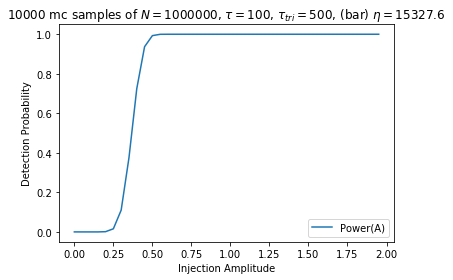

In [55]:
desired_pwr = 0.5
# already set above:
N = 10**6
tau = 100
tautri = 500
alpha = 10**(-4)
bar = 15327.6
Nmc = 10**4
plot_amps = np.genfromtxt('amps_pwrA2_10k6.csv', delimiter=',') #Avals
plot_pwrs = np.genfromtxt('pwrA2_10k6.csv', delimiter=',') #counts
# we find that for P(A > 1) = 1
namps = np.size(plot_amps)
plot_amps = plot_amps[:namps//2]
plot_pwrs = plot_pwrs[:namps//2]
# interpolate Pi(A) and find zero of Pi(A) - desired_pwr
amp_for_desired_pwr = spline(plot_amps, plot_pwrs - desired_pwr).roots()
print('\nfor power = ', desired_pwr, '\nneed amplitude = ', amp_for_desired_pwr, '\n')
plt.figure(656)
plt.plot(plot_amps, plot_pwrs)
plt.legend(['Power(A)'])
plt.xlabel('Injection Amplitude')
plt.ylabel('Detection Probability')
plt.title(str(Nmc) + ' mc samples of $N=$' + str(N) + ', $\\tau=$' + str(tau) + \
          ', $\\tau_{tri}=$' + str(tautri) + ', (bar) $\\eta=$' + str(bar))
plt.show(block=False)

comparing with the results from problem 1, this noise seems to allow us to reduce our 50% detection amplitude by roughly a factor of 2, making our test much more sensitive than in the case without convolution of the noise despite the fact that the increased effective number of independent samples leads to requiring a higher detection bar to achieve the same false alarm rate

the reason for the increase in sensitivity comes from the fact that we are now adding $A |s_{tri}|$ to the complex test statistic $z$ rather than $A \sqrt{\tau}$, as in the case of pure WGN, and in this case $\tau_{tri} = 5 \tau$

********
(d) $\textbf{about the 50% detection amplitude as a function of the Triangle's width:}$

$\textbf{Can you compute it analytically? (good approximation is OK) }$
********

assuming we are searching with the template of the same width as the injected signal, then we can make the good approximation that the maximal value of our test statistic will be at the value of $n_s$ corresponding to the start of the injected signal, in which case we have

$ 0.5 \approx P[(\Re(z_0) + A |s_{tri}|^2)^2 + \Im(z_0)^2 > \eta] = P[(\Re(\frac{z_0}{|s_{tri}|}) + A |s_{tri}|)^2 + \Im(\frac{z_0}{|s_{tri}|})^2 > \frac{\eta}{|s_{tri}|^2}] $

$ = 1 - F_{\chi^2(2, A^2 |s_{tri}|^2)}(\frac{\eta}{|s_{tri}|^2}) $

where $ F_{\chi^2(2, A^2 |s_{tri}|^2)}(\frac{\eta}{|s_{tri}|^2}) = 1 - Q_1(A |s_{tri}|, \frac{\sqrt{eta}}{|s_{tri}|}) $ is the CDF of a noncentral chi-squared distribution with 2 degrees of freedom and noncentrality parameter $A^2 |s_{tri}|^2$, which can be written in terms of the first order marcum q-function $ Q_1(A |s_{tri}|, \frac{\sqrt{\eta}}{|s_{tri}|}) = e^{-\frac{A^2 |s_{tri}|^2}{2}} \int_{\frac{\sqrt{\eta}}{|s_{tri}|}}^{\infty} x e^{-\frac{x^2}{2}} I_0(A |s_{tri}| x) dx $ 

several approximations to the inverse CDF of a noncentral chi-squared distribution exist, so one of those could be inverted (theoretically, although it gets very hairy trying to solve for the noncentrality parameter analytically even in the most simplified approximations to the inverse CDF of a noncentral chi-squared distribution) to approximate the 50% detection amplitude, but this does not seem like a productive use of time

let's instead return to the case of real-valued data and real WGN $w_n \sim N(0,1)$, where our test statistic is simply $ z = \sigma \cdot x = (D \hat{s}) \cdot (D x) $, which given an injected signal $A \hat{s}$ and normalized by $|s_{tri}| = |D \hat{s}|$ will be

$ \frac{1}{|s_{tri}|} z(\tau, n_s, \tau_{tri}; x = T w + A \hat{s}) = \frac{(D \hat{s}) \cdot w + A (D \hat{s}) \cdot (D \hat{s})}{|s_{tri}|} = \frac{z_0}{|s_{tri}|} + A |s_{tri}| \sim N(A |s_{tri}|, 1) $

$ \implies 0.5 \approx P[z(\tau, n_s, \tau_{tri}; x = T w + A \hat{s}) > \eta] = 1 - \Phi(\frac{\eta}{|s_{tri}|} - A |s_{tri}|) $

and since the median of the normal distribution is zero, $ \Phi(\frac{\eta}{|s_{tri}|} - A |s_{tri}|) = 0.5 $ gives

$ \frac{\eta}{|s_{tri}|} - A |s_{tri}| = 0 \implies A = \frac{\eta}{|s_{tri}|^2} $

for the case of real-valued data and noise (where the test statistic is simply $ z(\tau, n_s, \tau_{tri}; x) = \hat{s}^T D^T D x $)

however, the task remains to find $ |s_{tri}(\tau, n_s, \tau_{tri})| = |D(\tau_{tri}) \hat{s}(\tau, n_s)| = \sqrt{\sum_n (\hat{s}^T D^T D \hat{s})_n} = \frac{1}{\sqrt{N}} \sqrt{\sum_k |\frac{\tilde{\hat{s}}_k}{\tilde{t}_k}|^2} $ in terms of $\tau_{tri}$, which is far from straightforward to do analytically (although we might guess in analogy with the previous problem that it scales like $\sqrt{\tau_{tri}}$, and this checks out numerically)

********
3) You are looking for the same box as in (1), but suppose that the noise is of the following form:
n(t) = np.random.normal(0,1,10**6) convolved with a normalized filter of width 500 and unknown shape [normalized such that np.linalg.norm(filter)=1].
********

********
a) $\textbf{Is it possible to obtain a good estimator of the filter?}$

$\textbf{[Read about the Welch method AFTER trying to solve it yourself]}$
********

well, if it's possible to apply the filter $f_n$ to an injected signal, then injecting a noise-free unit impulse at any time $n$ would output a cyclic permutation of the filter 

if it's only possible to apply the filter to WGN plus injected signal, then the same method could be used by making the impulse height much larger than the WGN variance and repeating the procedure over many noise samples

if the filter never gets applied to the signal as in problem 2, but rather is only convolved with WGN, then all we have to work with is $n_n = \sum_{n'} f_{n - n'} w_{n'}$ and $\tilde{n}_k = \tilde{f}_k \tilde{w}_k$, with the relations $\tilde{n}_k = F[n_n]$ and $\sum_n |n_n|^2 = \frac{1}{N} \sum_k |\tilde{n}_k|^2$, so our best bet is to look at $|\tilde{n}_k|^2 = |\tilde{f}_k|^2 |\tilde{w}_k|^2$ for frequencies with excess power over many noise realizations to estimate the power spectrum of the filter $|\tilde{f}_k|^2$ (since $E[|\tilde{w}_k|^2] = 1$)

given an estimate of $|\tilde{f}_k|^2$, which gives the frequency amplitudes, it is not clear to me in general how we could determine the phases to reconstruct $f_n = F^{-1}[\tilde{f}_k]$, but if all we need are amplitudes then this should suffice given enough noise realizations to drive the sample average sufficiently close to the true power spectrum 

NOW READ ABOUT WELCH'S METHOD...

it seems that my strategy was essentially bartlett's method, except that my approach to getting good sample statistics assumes that we can generate noise realizations, whereas bartlett's and welch's methods treat just one stream of data, so their version of generating $N_{mc}$ noise realizations is to split the data stream into $N_{mc}$ segments

welch's method adds two features to bartlett's method: the data segments can overlap, and a window function can be applied to each segment 

let $o_m$ be our window function in the time domain, and consider dividing our $N$ time samples into $Q$ segments of length $L$ starting at length $R$ after the start of the previous segment, so $L - R$ is the length of the overlap between adjacent segments of windowed data

$ y_m(q) \equiv o_m x_{qR + m}, m = 0,1,...,L-1, q = 0,1,...,Q-1 $

with fourier coefficients

$ \tilde{y}_k(q) = \sum_{m=0}^{L-1} y_m(q) e^{-2 \pi i \frac{m k}{L}} = \sum_{k'=0}^{L-1} \tilde{o}_{k - k'} \tilde{x}_k(q) $,

where $ \tilde{x}_k(q) = \sum_{m=0}^{L-1} x_{qR + m} e^{-2 \pi i \frac{m k}{L}} $ and $ \tilde{o}_k = \sum_{m=0}^{L-1} o_m e^{-2 \pi i \frac{m k}{L}} $

then we define the periodogram of segment q,

$ G_k(q) \equiv \frac{1}{\sum_{m=0}^{L-1} |o_m|^2} |\tilde{y}_k(q)|^2 $

and our estimator for the filter's power spectrum $|\tilde{f}_k|^2$ is

$ P_k(L, R, Q, o_m; x_n) \equiv \frac{1}{Q} \sum_{q=0}^{Q-1} G_k(q) $

for which we must select the number of segments $Q$, their length $L$, their offset length $R$ (which determines the overlap $L-R$), and the window function $o_m$

if we choose the unit height rectangle of length $L$ as our window function, with $Q = 1$ and $L = R = N$, then $P_k$ is just a periodogram of the data, which is an unbiased estimator in the infinite sampling limit because $E[P_k(N,N,1,rect_n(N); f_n * w_n)] \rightarrow |\tilde{f}_k|^2$ as $N \rightarrow \infty$, but its variance $Var(P_k(N,N,1,rect_n(N); f_n * w_n)) = |\tilde{f}_k|^2$ cannot be reduced no matter how much data we use, making it an inconsistent estimator even in the infinite sampling limit

keeping the simple truncation window function (rectangular window) and using $Q > 1$ with $L = R = \frac{N}{Q}$ constitutes bartlett's method, which averages non-overlapping periodograms to get an estimator with (in the case of stationary noise, so the data segments are independent) $Var(P_k(N,N,1,rect_n(N); f_n * w_n)) = \frac{1}{Q} |\tilde{f}_k|^2 \rightarrow 0$ as $Q \rightarrow \infty$, making it asymptotically consistent in the number of segments, and remaining unbiased in the limit of infinite samples per segment

however, for a fixed number of total samples $N = Q L$, there is the expected tradoff between bias, which scales with $\frac{1}{L}$, and inconsistency (variance), which scales with $\frac{1}{Q}$

welch's method tries to squeeze the most out of this tradeoff by allowing segment overlap, so that more segments can be used without reducing segment length, and using a window function to reduce the dependence between overlapping segments, because using dependent segments means that the variance will scale like $Q^{-p}$, with $p < 1$ tending to zero as the segments become fully dependent (as in the case of the periodogram)

thus, we try to use a window function and overlap that optimizes this tradeoff, and one more consideration to include is the frequency resolution, which improves to that of the full dataset as $L \rightarrow N$

more specifically, say that our original $N$ sample points span a total time of $T_N \equiv N \Delta t$, then our sampling rate is $\nu_s = \frac{1}{\Delta t} = \frac{N}{T_N}$ and the corresponding nyquist frequency is $\nu_{nyq} = \frac{\nu_s}{2} = \frac{N}{2 T_N}$, which bounds our frequency space domain to the interval $[-\nu_{nyq}, \nu_{nyq}]$ with resolution $\Delta \nu = \frac{2 \nu_{nyq}}{N} = \frac{1}{T_N}$

if we then consider data windows of $L$ sample points, we have the same sampling rate and therefore the same nyquist frequency bounding our frequency domain, but covering that domain with only $L$ frequencies reduces our resolution (i.e., increases our DFT frequency bin size) to $\frac{2 \nu_{nyq}}{L} = \frac{N}{L T_N} = \frac{N}{L} \Delta \nu$

if we let $\Delta t = 1$ define our time units, then we say that the frequency resolution of our data is $\frac{1}{N}$ and the resolution of our approximation is $\frac{1}{L}$

the way to choose optimal estimation parameters varies depending on the purpose of the estimate, and in our case the goal is to whiten the convolved noise, meaning that we want to divide out deviations from WGN in frequency space, but we don't want to divide by large values at frequencies where the filter does not have large values, because that could unnecessarily diminish parts of the data containing signal (thus reducing detection sensitivity)

so, we want the resolution of $P_k$ to be as narrow as the narrowest significant frequency peak in the filter -- since the filter has unknown shape but known time duration $\tau_f \Delta t$, we can make the crude approximation that its bandwidth is at least $\frac{1}{2 \tau_f \Delta t}$, so we should use $L > 2 \tau_f$ points per segment

in practice, a better way to set this minumum length per segment is to look at the PSD of the data, which we assume is dominated by noise and therefore any frequency peaks we see can be assumed to come from noise, and then choose a resolution corresponding to the narrowest observed peak

let's examine numerically which window function and segment length give the best results, letting the overlap fraction be fixed at $\frac{L - R}{L} = \frac{1}{2}$ and using all data points with no zero padding

In [35]:
# get Q from L and R assuming you want to use all data points
# and have no segments with zero padding or wrapping
def Qfull(N, L, R=None):
    if R == None:
        R = int(L/2)
    return 1 + int((N - L)/R)

# get welch estimate of filter from 
# data = filter convolved with WGN 
# L is segment length, R is offset, so overlap is L-R
# Q is number of segments and o_m is window (assumed length L)
# need Q <= 1 + (data.size - L)/R
def welch_psd(data, o_m, L=None, R=None, Q=None):
    if L == None:
        L = o_m.size
    if R == None:
        R = int(L/2)
    if Q == None:
        Q = Qfull(data.size, L, R)
    Gkq = np.zeros(L)
    for q in np.arange(Q):
        Gkq += abs2(fft(o_m * data[q*R:q*R+L]))
    return Gkq / (2*Q*np.sum(abs2(o_m)))
# why do we need the factor of 2?

import scipy.signal as ssp
from numpy.fft import fftshift as centered
from scipy.signal import get_window as window
# call as window(('name' [, params]), L) 
# 'gaussian' (needs std), 'boxcar' for rect, 'triang', 'hamming', others
# ('tukey', alpha=0.5) for rectangular for 1-alpha of region,
# tapered at sides with cosine for alpha of region

# OR use pre-packaged version!
#ssp.welch(x, fs=1.0, window='hanning', nperseg=256, noverlap=None, nfft=None, \
#          detrend='constant', return_onesided=True, scaling='density', axis=-1)
# noverlap=None gives nperseg/2 (50%), nfft=None gives nperseg

def ssp_welch(data, o_m):
    freqs, ssp_psd = ssp.welch(data, window=o_m, return_onesided=False, detrend=False)
    return ssp_psd

# convert low res approx to full length = arr.size * factor
@jit(nopython=True)
def bins_to_resolution(arr, factor):
    new_arr = np.empty(arr.size * factor)
    for i, val in enumerate(arr):
        for j in np.arange(factor):
            new_arr[i*factor + j] = val
    return new_arr

b2r = bins_to_resolution

def psdplot(pxx, krange=1000):
    plt.plot(np.arange(-krange, krange+1), \
             centered(pxx)[int(pxx.size/2) - krange:int(pxx.size/2) + krange + 1])
    plt.xlabel('frequency number (k)')
    plt.ylabel('power ($|\\tilde{x}_k|^2$)')
    plt.title('power spectral density')
    plt.show(block=False)
    return

def psdplot2(pxx_est, pxx_tru, krange=1000):
    kk = np.arange(-krange, krange+1)
    nN = pxx_tru.size
    i0 = int(nN/2) - krange
    i1 = int(nn/2) + krange + 1
    plt.plot(kk, centered(b2r(pxx_est, int(nN/pxx_est.size)))[i0:i1])
    plt.plot(kk, centered(pxx_tru)[i0:i1])
    plt.legend(['estimate','exact'])
    plt.xlabel('frequency number (k)')
    plt.ylabel('power ($|\\tilde{x}_k|^2$)')
    plt.title('power spectral density')
    plt.show(block=False)
    return
    

# now let's compare the various welch estimates by computing test statistic
# N_mc times for each (L, R, Q, o_m) = (L, L/2, 2N/L - 1, o_m)
# get max|z|^2 from data and template s(tau) using window function o_m to estimate psd
# and providing revsig_ft_conj = np.conj(get_revsig_ft(N, tau))
def compute_stat_welch(data, revsig_ft_conj, o_m):
    psd = welch_psd(data, o_m)
    return np.max(abs2(np.fft.ifft(revsig_ft_conj * np.fft.fft(data) / \
                                   bins_to_resolution(psd, int(data.size / psd.size)))))

# return squared fractional error of psd estimate 
def compute_msfe_welch(data, tru_psd, o_m):
    psd = welch_psd(data, o_m)
    return abs2((tru_psd - bins_to_resolution(psd, int(data.size / psd.size)))/tru_psd)

# return mean and variance of true_psd - welch_psd
def compute_mean_var_welch(data, tru_psd, o_m):
    dif = tru_psd - b2r(welch_psd(data, o_m), int(data.size / o_m.size))
    return np.array([np.mean(dif), np.var(dif)])

def camp(cc):
    return cc * np.exp(1j*2*np.pi*np.random.random())

def csig(cc, nn=1000000, tau=100):
    return camp(cc) * get_signal(nn, tau, start=np.random.randint(0,nn))

********
b) $\textbf{What is the impact of using the best-estimate filter in the detection statistic }$

$\textbf{computed in (2)?   Is this hampering detection at all?}$
********

well, let's first find out what the "best-estimate filter" is by trying different window functions and segment lengths

In [19]:
nn = 10**6
tau = 100
tautri = 500
tt_ft = np.fft.fft(get_tri_right(nn,tautri))
revsig_ft_cc = np.conj(get_revsig_ft(nn, tau))
sigma_ft_cc = revsig_ft_cc / abs2(tt_ft)
tru_stats = np.empty((10,3,3))
ogauss2000s100 = window(('gaussian', 100), 2000)
ogauss2000s200 = window(('gaussian', 200), 2000)
ogauss2000s400 = window(('gaussian', 400), 2000)
ogauss5000s250 = window(('gaussian', 250), 5000)
ogauss5000s500 = window(('gaussian', 500), 5000)
ogauss5000s1000 = window(('gaussian', 1000), 5000)
ogauss10000s500 = window(('gaussian', 500), 10000)
ogauss10000s1000 = window(('gaussian', 1000), 10000)
ogauss10000s2000 = window(('gaussian', 2000), 10000)
otukey2000 = window(('tukey', 0.5), 2000)
otukey5000 = window(('tukey', 0.5), 5000)
otukey10000 = window(('tukey', 0.5), 10000)
ohamm2000 = window('hamming', 2000)
ohamm5000 = window('hamming', 5000)
ohamm10000 = window('hamming', 10000)
ohann2000 = window('hann', 2000)
ohann5000 = window('hann', 5000)
ohann10000 = window('hann', 10000)
otri2000 = window('triang', 2000)
otri5000 = window('triang', 5000)
otri10000 = window('triang', 10000)
orect2000 = window('boxcar', 2000)
orect5000 = window('boxcar', 5000)
orect10000 = window('boxcar', 10000)
gauss2000s100 = np.empty((10,3,3))
gauss2000s200 = np.empty((10,3,3))
gauss2000s400 = np.empty((10,3,3))
gauss5000s250 = np.empty((10,3,3))
gauss5000s500 = np.empty((10,3,3))
gauss5000s1000 = np.empty((10,3,3))
gauss10000s500 = np.empty((10,3,3))
gauss10000s1000 = np.empty((10,3,3))
gauss10000s2000 = np.empty((10,3,3))
tukey2000 = np.empty((10,3,3))
tukey5000 = np.empty((10,3,3))
tukey10000 = np.empty((10,3,3))
hamm2000 = np.empty((10,3,3))
hamm5000 = np.empty((10,3,3))
hamm10000 = np.empty((10,3,3))
hann2000 = np.empty((10,3,3))
hann5000 = np.empty((10,3,3))
hann10000 = np.empty((10,3,3))
tri2000 = np.empty((10,3,3))
tri5000 = np.empty((10,3,3))
tri10000 = np.empty((10,3,3))
rect2000 = np.empty((10,3,3))
rect5000 = np.empty((10,3,3))
rect10000 = np.empty((10,3,3))

In [13]:
ns_vals = np.random.randint(0, nn, size=3)
phi_vals = 2*np.pi*np.random.random(3)
sigs = np.empty((3, nn), dtype=np.csingle)
sigs[0] = np.exp(1j*phi_vals[0]) * get_signal(nn, tau, start=ns_vals[0])
sigs[1] = np.exp(1j*phi_vals[1]) * get_signal(nn, tau, start=ns_vals[1])
sigs[2] = np.exp(1j*phi_vals[2]) * get_signal(nn, tau, start=ns_vals[2])
amps = np.array([0.1, 0.2, 0.4])

In [11]:
for ii in np.arange(10):
    # get 10 realizations of noise to average over for each signal
    noise = np.fft.ifft(np.fft.fft(get_wgn(nn)) * tt_ft)
    for jj in np.arange(3):
        # for each noise realization get stat for all signals
        # (there is certainly a more efficient way to implement this)
        for kk in np.arange(3):
            x = noise + amps[kk]*sigs[jj]
            tru_stats[ii,jj,kk] = np.max(abs2(np.fft.ifft(sigma_ft_cc * np.fft.fft(x))))
            gauss2000s100[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, ogauss2000s100)
            gauss2000s200[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, ogauss2000s200)
            gauss2000s400[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, ogauss2000s400)
            gauss5000s250[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, ogauss5000s250)
            gauss5000s500[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, ogauss5000s500)
            gauss5000s1000[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, ogauss5000s1000)
            gauss10000s500[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, ogauss10000s500)
            gauss10000s1000[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, ogauss10000s1000)
            gauss10000s2000[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, ogauss10000s2000)
            tukey2000[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, otukey2000)
            tukey5000[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, otukey5000)
            tukey10000[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, otukey10000)
            hamm2000[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, ohamm2000)
            hamm5000[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, ohamm5000)
            hamm10000[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, ohamm10000)
            hann2000[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, ohann2000)
            hann5000[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, ohann5000)
            hann10000[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, ohann10000)
            tri2000[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, otri2000)
            tri5000[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, otri5000)
            tri10000[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, otri10000)
            rect2000[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, orect2000)
            rect5000[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, orect5000)
            rect10000[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, orect10000)

In [12]:
tru_statsavg = np.sum(np.sum(tru_stats, axis=0), axis=0)/30
gauss2000s100avg = np.sum(np.sum(gauss2000s100, axis=0), axis=0)/30
gauss2000s200avg = np.sum(np.sum(gauss2000s200, axis=0), axis=0)/30
gauss2000s400avg = np.sum(np.sum(gauss2000s400, axis=0), axis=0)/30
gauss5000s250avg = np.sum(np.sum(gauss5000s250, axis=0), axis=0)/30
gauss5000s500avg = np.sum(np.sum(gauss5000s500, axis=0), axis=0)/30
gauss5000s1000avg = np.sum(np.sum(gauss5000s1000, axis=0), axis=0)/30
gauss10000s500avg = np.sum(np.sum(gauss10000s500, axis=0), axis=0)/30
gauss10000s1000avg = np.sum(np.sum(gauss10000s1000, axis=0), axis=0)/30
gauss10000s2000avg = np.sum(np.sum(gauss10000s2000, axis=0), axis=0)/30
tukey2000avg = np.sum(np.sum(tukey2000, axis=0), axis=0)/30
tukey5000avg = np.sum(np.sum(tukey5000, axis=0), axis=0)/30
tukey10000avg = np.sum(np.sum(tukey10000, axis=0), axis=0)/30
hamm2000avg = np.sum(np.sum(hamm2000, axis=0), axis=0)/30
hamm5000avg = np.sum(np.sum(hamm5000, axis=0), axis=0)/30
hamm10000avg = np.sum(np.sum(hamm10000, axis=0), axis=0)/30
hann2000avg = np.sum(np.sum(hann2000, axis=0), axis=0)/30
hann5000avg = np.sum(np.sum(hann5000, axis=0), axis=0)/30
hann10000avg = np.sum(np.sum(hann10000, axis=0), axis=0)/30
tri2000avg = np.sum(np.sum(tri2000, axis=0), axis=0)/30
tri5000avg = np.sum(np.sum(tri5000, axis=0), axis=0)/30
tri10000avg = np.sum(np.sum(tri10000, axis=0), axis=0)/30
rect2000avg = np.sum(np.sum(rect2000, axis=0), axis=0)/30
rect5000avg = np.sum(np.sum(rect5000, axis=0), axis=0)/30
rect10000avg = np.sum(np.sum(rect10000, axis=0), axis=0)/30

In [17]:
def fmt(num):
    return '{:.1f}'.format(num)

rownames = ['exact', 'gauss0', 'gauss1', 'gauss2', 'tukey', 'hamm', 'hann', 'tri', 'rect']
colnames = ['L=2k, A=.1','L=2k, A=.2','L=2k, A=.4','L=5k, A=.1','L=5k, A=.2','L=5k, A=.4',\
            'L=10k, A=.1','L=10k, A=.2','L=10k, A=.4']
celltext = [[fmt(zz) for zz in tru_statsavg], [fmt(zz) for zz in gauss2000s100avg], \
            [fmt(zz) for zz in gauss2000s200avg], [fmt(zz) for zz in gauss2000s400avg], \
            [fmt(zz) for zz in tukey2000avg], [fmt(zz) for zz in hamm2000avg], \
            [fmt(zz) for zz in hann2000avg], [fmt(zz) for zz in tri2000avg], \
            [fmt(zz) for zz in rect2000avg]]
celltext[0] += [fmt(zz) for zz in tru_statsavg] + [fmt(zz) for zz in tru_statsavg]
celltext[1] += [fmt(zz) for zz in gauss5000s250avg] + [fmt(zz) for zz in gauss10000s500avg]
celltext[2] += [fmt(zz) for zz in gauss5000s500avg] + [fmt(zz) for zz in gauss10000s1000avg]
celltext[3] += [fmt(zz) for zz in gauss5000s1000avg] + [fmt(zz) for zz in gauss10000s2000avg]
celltext[4] += [fmt(zz) for zz in tukey5000avg] + [fmt(zz) for zz in tukey10000avg]
celltext[5] += [fmt(zz) for zz in hamm5000avg] + [fmt(zz) for zz in hamm10000avg]
celltext[6] += [fmt(zz) for zz in hamm10000avg] + [fmt(zz) for zz in hann10000avg]
celltext[7] += [fmt(zz) for zz in tri5000avg] + [fmt(zz) for zz in tri10000avg]
celltext[8] += [fmt(zz) for zz in rect5000avg] + [fmt(zz) for zz in rect10000avg]


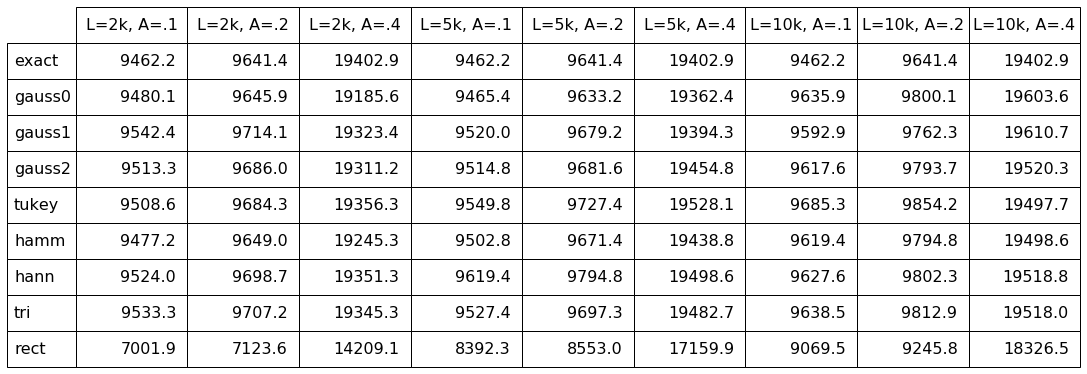

In [23]:
fig, ax = plt.subplots()
#ax.xaxis.set_visible(False) 
#ax.yaxis.set_visible(False)
ax.axis('off')
the_table = plt.table(cellText=celltext, rowLabels=rownames, colLabels=colnames, loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)
the_table.scale(3, 3)
#plt.savefig('welch_data.png')

it appears that all of the non-rectangular windows tested above give test statistics comparable to the exact result for the case of problem 2, but which one can we trust the most - that is, which gives us the closest to the true psd?

In [52]:
# first check the mean squared fractional error
msegauss2000s100 = 0.0
msegauss2000s200 = 0.0
msegauss2000s400 = 0.0
msegauss5000s250 = 0.0
msegauss5000s500 = 0.0
msegauss5000s1000 = 0.0
msegauss10000s500 = 0.0
msegauss10000s1000 = 0.0
msegauss10000s2000 = 0.0
msetukey2000 = 0.0
msetukey5000 = 0.0
msetukey10000 = 0.0
msehamm2000 = 0.0
msehamm5000 = 0.0
msehamm10000 = 0.0
msehann2000 = 0.0
msehann5000 = 0.0
msehann10000 = 0.0
msetri2000 = 0.0
msetri5000 = 0.0
msetri10000 = 0.0
nn = 10**6
tau = 100
tautri = 500
tt_ft = np.fft.fft(get_tri_right(nn,tautri))
tt_psd = abs2(tt_ft)
cc = 1.0/(nn*100.0)
for ii in np.arange(100):
    # get 50 realizations of noise to average over for psd estimate msfe
    x = np.fft.ifft(np.fft.fft(get_wgn(nn)) * tt_ft)
    msegauss2000s100 += np.sum(compute_msfe_welch(x, tt_psd, ogauss2000s100))*cc
    msegauss2000s200 += np.sum(compute_msfe_welch(x, tt_psd, ogauss2000s200))*cc
    msegauss2000s400 += np.sum(compute_msfe_welch(x, tt_psd, ogauss2000s400))*cc
    msegauss5000s250 += np.sum(compute_msfe_welch(x, tt_psd, ogauss5000s250))*cc
    msegauss5000s500 += np.sum(compute_msfe_welch(x, tt_psd, ogauss5000s500))*cc
    msegauss5000s1000 += np.sum(compute_msfe_welch(x, tt_psd, ogauss5000s1000))*cc
    msegauss10000s500 += np.sum(compute_msfe_welch(x, tt_psd, ogauss10000s500))*cc
    msegauss10000s1000 += np.sum(compute_msfe_welch(x, tt_psd, ogauss10000s1000))*cc
    msegauss10000s2000 += np.sum(compute_msfe_welch(x, tt_psd, ogauss10000s2000))*cc
    msetukey2000 += np.sum(compute_msfe_welch(x, tt_psd, otukey2000))*cc
    msetukey5000 += np.sum(compute_msfe_welch(x, tt_psd, otukey5000))*cc
    msetukey10000 += np.sum(compute_msfe_welch(x, tt_psd, otukey10000))*cc
    msehamm2000 += np.sum(compute_msfe_welch(x, tt_psd, ohamm2000))*cc
    msehamm5000 += np.sum(compute_msfe_welch(x, tt_psd, ohamm5000))*cc
    msehamm10000 += np.sum(compute_msfe_welch(x, tt_psd, ohamm10000))*cc
    msehann2000 += np.sum(compute_msfe_welch(x, tt_psd, ohann2000))*cc
    msehann5000 += np.sum(compute_msfe_welch(x, tt_psd, ohann5000))*cc
    msehann10000 += np.sum(compute_msfe_welch(x, tt_psd, ohann10000))*cc
    msetri2000 += np.sum(compute_msfe_welch(x, tt_psd, otri2000))*cc
    msetri5000 += np.sum(compute_msfe_welch(x, tt_psd, otri5000))*cc
    msetri10000 += np.sum(compute_msfe_welch(x, tt_psd, otri10000))*cc

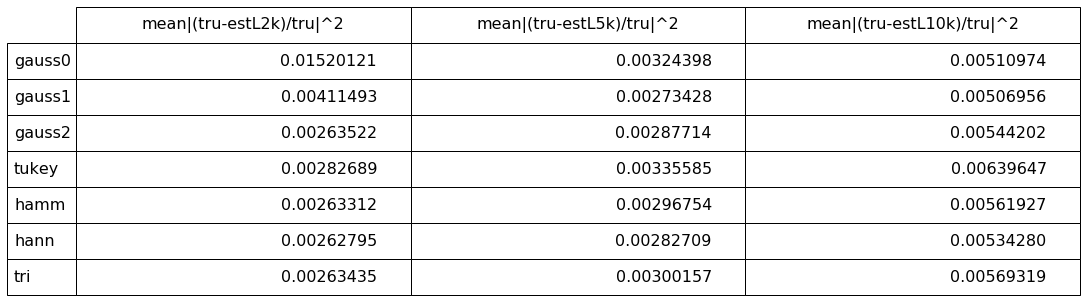

In [53]:
def fmt(num):
    return '{:.8f}'.format(num)

msfe_data = [[fmt(msegauss2000s100),fmt(msegauss5000s250),fmt(msegauss10000s500)],
             [fmt(msegauss2000s200),fmt(msegauss5000s500),fmt(msegauss10000s1000)],
             [fmt(msegauss2000s400),fmt(msegauss5000s1000),fmt(msegauss10000s2000)],
             [fmt(msetukey2000),fmt(msetukey5000),fmt(msetukey10000)],
             [fmt(msehamm2000),fmt(msehamm5000),fmt(msehamm10000)],
             [fmt(msehann2000),fmt(msehann5000),fmt(msehann10000)],
             [fmt(msetri2000),fmt(msetri5000),fmt(msetri10000)]]
rownames = ['gauss0', 'gauss1', 'gauss2', 'tukey', 'hamm', 'hann', 'tri']
fig, ax = plt.subplots()
ax.axis('off')
the_table = plt.table(cellText=msfe_data, rowLabels=rownames, \
                      colLabels=['mean|(tru-estL2k)/tru|^2','mean|(tru-estL5k)/tru|^2',\
                                 'mean|(tru-estL10k)/tru|^2'], loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)
the_table.scale(3, 3)

In [20]:
# now check the mean and variance of estimated_psd - true_psd
mvgauss2000s100 = np.zeros(2)
mvgauss2000s200 = np.zeros(2)
mvgauss2000s400 = np.zeros(2)
mvgauss5000s250 = np.zeros(2)
mvgauss5000s500 = np.zeros(2)
mvgauss5000s1000 = np.zeros(2)
mvgauss10000s500 = np.zeros(2)
mvgauss10000s1000 = np.zeros(2)
mvgauss10000s2000 = np.zeros(2)
mvtukey2000 = np.zeros(2)
mvtukey5000 = np.zeros(2)
mvtukey10000 = np.zeros(2)
mvhamm2000 = np.zeros(2)
mvhamm5000 = np.zeros(2)
mvhamm10000 = np.zeros(2)
mvhann2000 = np.zeros(2)
mvhann5000 = np.zeros(2)
mvhann10000 = np.zeros(2)
mvtri2000 = np.zeros(2)
mvtri5000 = np.zeros(2)
mvtri10000 = np.zeros(2)
nn = 10**6
tau = 100
tautri = 500
tt_ft = np.fft.fft(get_tri_right(nn,tautri))
tt_psd = abs2(tt_ft)
for ii in np.arange(100):
    # get 100 realizations of noise to average over
    x = np.fft.ifft(np.fft.fft(get_wgn(nn)) * tt_ft)
    mvgauss2000s100 += compute_mean_var_welch(x, tt_psd, ogauss2000s100)*0.01
    mvgauss2000s200 += compute_mean_var_welch(x, tt_psd, ogauss2000s200)*0.01
    mvgauss2000s400 += compute_mean_var_welch(x, tt_psd, ogauss2000s400)*0.01
    mvgauss5000s250 += compute_mean_var_welch(x, tt_psd, ogauss5000s250)*0.01
    mvgauss5000s500 += compute_mean_var_welch(x, tt_psd, ogauss5000s500)*0.01
    mvgauss5000s1000 += compute_mean_var_welch(x, tt_psd, ogauss5000s1000)*0.01
    mvgauss10000s500 += compute_mean_var_welch(x, tt_psd, ogauss10000s500)*0.01
    mvgauss10000s1000 += compute_mean_var_welch(x, tt_psd, ogauss10000s1000)*0.01
    mvgauss10000s2000 += compute_mean_var_welch(x, tt_psd, ogauss10000s2000)*0.01
    mvtukey2000 += compute_mean_var_welch(x, tt_psd, otukey2000)*0.01
    mvtukey5000 += compute_mean_var_welch(x, tt_psd, otukey5000)*0.01
    mvtukey10000 += compute_mean_var_welch(x, tt_psd, otukey10000)*0.01
    mvhamm2000 += compute_mean_var_welch(x, tt_psd, ohamm2000)*0.01
    mvhamm5000 += compute_mean_var_welch(x, tt_psd, ohamm5000)*0.01
    mvhamm10000 += compute_mean_var_welch(x, tt_psd, ohamm10000)*0.01
    mvhann2000 += compute_mean_var_welch(x, tt_psd, ohann2000)*0.01
    mvhann5000 += compute_mean_var_welch(x, tt_psd, ohann5000)*0.01
    mvhann10000 += compute_mean_var_welch(x, tt_psd, ohann10000)*0.01
    mvtri2000 += compute_mean_var_welch(x, tt_psd, otri2000)*0.01
    mvtri5000 += compute_mean_var_welch(x, tt_psd, otri5000)*0.01
    mvtri10000 += compute_mean_var_welch(x, tt_psd, otri10000)*0.01

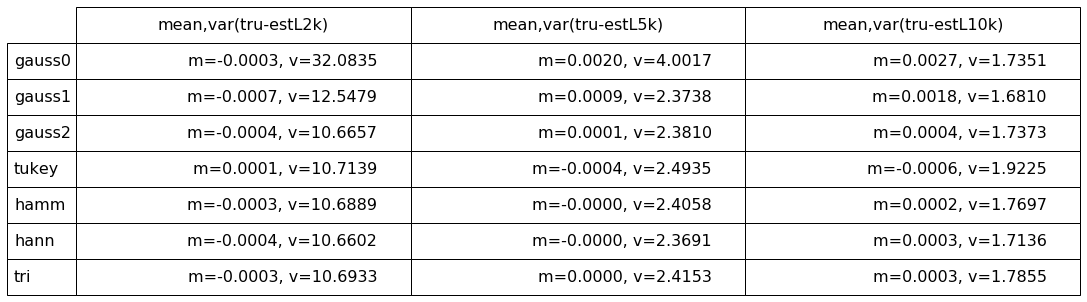

In [23]:
def fmt2(nums):
    return 'm={:.4f}, v={:.4f}'.format(nums[0], nums[1])

mv_data = [[fmt2(mvgauss2000s100),fmt2(mvgauss5000s250),fmt2(mvgauss10000s500)],
             [fmt2(mvgauss2000s200),fmt2(mvgauss5000s500),fmt2(mvgauss10000s1000)],
             [fmt2(mvgauss2000s400),fmt2(mvgauss5000s1000),fmt2(mvgauss10000s2000)],
             [fmt2(mvtukey2000),fmt2(mvtukey5000),fmt2(mvtukey10000)],
             [fmt2(mvhamm2000),fmt2(mvhamm5000),fmt2(mvhamm10000)],
             [fmt2(mvhann2000),fmt2(mvhann5000),fmt2(mvhann10000)],
             [fmt2(mvtri2000),fmt2(mvtri5000),fmt2(mvtri10000)]]
rownames = ['gauss0', 'gauss1', 'gauss2', 'tukey', 'hamm', 'hann', 'tri']
fig, ax = plt.subplots()
ax.axis('off')
the_table = plt.table(cellText=mv_data, rowLabels=rownames, \
                      colLabels=['mean,var(tru-estL2k)','mean,var(tru-estL5k)',\
                                 'mean,var(tru-estL10k)'], loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)
the_table.scale(3, 3)

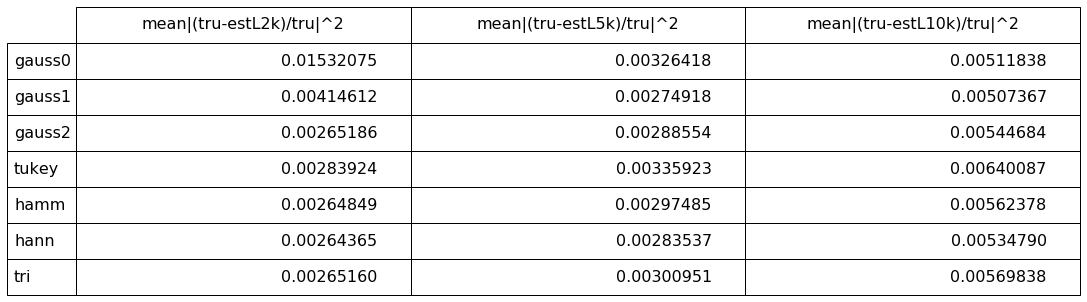

In [54]:
# NOW REPEAT WITH SIGNAL (H1)

def fmt(num):
    return '{:.8f}'.format(num)

def camp(cc):
    return cc * np.exp(1j*2*np.pi*np.random.random())

msegauss2000s100 = 0.0
msegauss2000s200 = 0.0
msegauss2000s400 = 0.0
msegauss5000s250 = 0.0
msegauss5000s500 = 0.0
msegauss5000s1000 = 0.0
msegauss10000s500 = 0.0
msegauss10000s1000 = 0.0
msegauss10000s2000 = 0.0
msetukey2000 = 0.0
msetukey5000 = 0.0
msetukey10000 = 0.0
msehamm2000 = 0.0
msehamm5000 = 0.0
msehamm10000 = 0.0
msehann2000 = 0.0
msehann5000 = 0.0
msehann10000 = 0.0
msetri2000 = 0.0
msetri5000 = 0.0
msetri10000 = 0.0
nn = 10**6
tau = 100
tautri = 500
tt_ft = np.fft.fft(get_tri_right(nn,tautri))
tt_psd = abs2(tt_ft)
cc = 1.0/(nn*100.0)
for ii in np.arange(100):
    # get 100 realizations of noise to average over for psd estimate mse
    x = (np.fft.ifft(np.fft.fft(get_wgn(nn)) * tt_ft) + csig(0.3, nn, tau)
    msegauss2000s100 += np.sum(compute_msfe_welch(x, tt_psd, ogauss2000s100))*cc
    msegauss2000s200 += np.sum(compute_msfe_welch(x, tt_psd, ogauss2000s200))*cc
    msegauss2000s400 += np.sum(compute_msfe_welch(x, tt_psd, ogauss2000s400))*cc
    msegauss5000s250 += np.sum(compute_msfe_welch(x, tt_psd, ogauss5000s250))*cc
    msegauss5000s500 += np.sum(compute_msfe_welch(x, tt_psd, ogauss5000s500))*cc
    msegauss5000s1000 += np.sum(compute_msfe_welch(x, tt_psd, ogauss5000s1000))*cc
    msegauss10000s500 += np.sum(compute_msfe_welch(x, tt_psd, ogauss10000s500))*cc
    msegauss10000s1000 += np.sum(compute_msfe_welch(x, tt_psd, ogauss10000s1000))*cc
    msegauss10000s2000 += np.sum(compute_msfe_welch(x, tt_psd, ogauss10000s2000))*cc
    msetukey2000 += np.sum(compute_msfe_welch(x, tt_psd, otukey2000))*cc
    msetukey5000 += np.sum(compute_msfe_welch(x, tt_psd, otukey5000))*cc
    msetukey10000 += np.sum(compute_msfe_welch(x, tt_psd, otukey10000))*cc
    msehamm2000 += np.sum(compute_msfe_welch(x, tt_psd, ohamm2000))*cc
    msehamm5000 += np.sum(compute_msfe_welch(x, tt_psd, ohamm5000))*cc
    msehamm10000 += np.sum(compute_msfe_welch(x, tt_psd, ohamm10000))*cc
    msehann2000 += np.sum(compute_msfe_welch(x, tt_psd, ohann2000))*cc
    msehann5000 += np.sum(compute_msfe_welch(x, tt_psd, ohann5000))*cc
    msehann10000 += np.sum(compute_msfe_welch(x, tt_psd, ohann10000))*cc
    msetri2000 += np.sum(compute_msfe_welch(x, tt_psd, otri2000))*cc
    msetri5000 += np.sum(compute_msfe_welch(x, tt_psd, otri5000))*cc
    msetri10000 += np.sum(compute_msfe_welch(x, tt_psd, otri10000))*cc

msfe_data = [[fmt(msegauss2000s100),fmt(msegauss5000s250),fmt(msegauss10000s500)],
             [fmt(msegauss2000s200),fmt(msegauss5000s500),fmt(msegauss10000s1000)],
             [fmt(msegauss2000s400),fmt(msegauss5000s1000),fmt(msegauss10000s2000)],
             [fmt(msetukey2000),fmt(msetukey5000),fmt(msetukey10000)],
             [fmt(msehamm2000),fmt(msehamm5000),fmt(msehamm10000)],
             [fmt(msehann2000),fmt(msehann5000),fmt(msehann10000)],
             [fmt(msetri2000),fmt(msetri5000),fmt(msetri10000)]]
rownames = ['gauss0', 'gauss1', 'gauss2', 'tukey', 'hamm', 'hann', 'tri']
fig, ax = plt.subplots()
ax.axis('off')
the_table = plt.table(cellText=msfe_data, rowLabels=rownames, \
                      colLabels=['mean|(tru-estL2k)/tru|^2','mean|(tru-estL5k)/tru|^2',\
                                 'mean|(tru-estL10k)/tru|^2'], loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)
the_table.scale(3, 3)

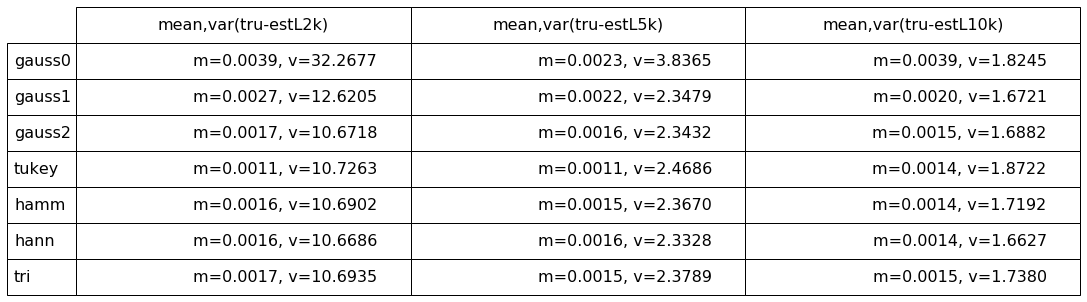

In [24]:
# now check the mean and variance of estimated_psd - true_psd
mvgauss2000s100 = np.zeros(2)
mvgauss2000s200 = np.zeros(2)
mvgauss2000s400 = np.zeros(2)
mvgauss5000s250 = np.zeros(2)
mvgauss5000s500 = np.zeros(2)
mvgauss5000s1000 = np.zeros(2)
mvgauss10000s500 = np.zeros(2)
mvgauss10000s1000 = np.zeros(2)
mvgauss10000s2000 = np.zeros(2)
mvtukey2000 = np.zeros(2)
mvtukey5000 = np.zeros(2)
mvtukey10000 = np.zeros(2)
mvhamm2000 = np.zeros(2)
mvhamm5000 = np.zeros(2)
mvhamm10000 = np.zeros(2)
mvhann2000 = np.zeros(2)
mvhann5000 = np.zeros(2)
mvhann10000 = np.zeros(2)
mvtri2000 = np.zeros(2)
mvtri5000 = np.zeros(2)
mvtri10000 = np.zeros(2)
nn = 10**6
tau = 100
tautri = 500
tt_ft = np.fft.fft(get_tri_right(nn,tautri))
tt_psd = abs2(tt_ft)
for ii in np.arange(100):
    # get 100 realizations of noise to average over
    x = (np.fft.ifft(np.fft.fft(get_wgn(nn)) * tt_ft) + csig(0.3, nn, tau)
    mvgauss2000s100 += compute_mean_var_welch(x, tt_psd, ogauss2000s100)*0.01
    mvgauss2000s200 += compute_mean_var_welch(x, tt_psd, ogauss2000s200)*0.01
    mvgauss2000s400 += compute_mean_var_welch(x, tt_psd, ogauss2000s400)*0.01
    mvgauss5000s250 += compute_mean_var_welch(x, tt_psd, ogauss5000s250)*0.01
    mvgauss5000s500 += compute_mean_var_welch(x, tt_psd, ogauss5000s500)*0.01
    mvgauss5000s1000 += compute_mean_var_welch(x, tt_psd, ogauss5000s1000)*0.01
    mvgauss10000s500 += compute_mean_var_welch(x, tt_psd, ogauss10000s500)*0.01
    mvgauss10000s1000 += compute_mean_var_welch(x, tt_psd, ogauss10000s1000)*0.01
    mvgauss10000s2000 += compute_mean_var_welch(x, tt_psd, ogauss10000s2000)*0.01
    mvtukey2000 += compute_mean_var_welch(x, tt_psd, otukey2000)*0.01
    mvtukey5000 += compute_mean_var_welch(x, tt_psd, otukey5000)*0.01
    mvtukey10000 += compute_mean_var_welch(x, tt_psd, otukey10000)*0.01
    mvhamm2000 += compute_mean_var_welch(x, tt_psd, ohamm2000)*0.01
    mvhamm5000 += compute_mean_var_welch(x, tt_psd, ohamm5000)*0.01
    mvhamm10000 += compute_mean_var_welch(x, tt_psd, ohamm10000)*0.01
    mvhann2000 += compute_mean_var_welch(x, tt_psd, ohann2000)*0.01
    mvhann5000 += compute_mean_var_welch(x, tt_psd, ohann5000)*0.01
    mvhann10000 += compute_mean_var_welch(x, tt_psd, ohann10000)*0.01
    mvtri2000 += compute_mean_var_welch(x, tt_psd, otri2000)*0.01
    mvtri5000 += compute_mean_var_welch(x, tt_psd, otri5000)*0.01
    mvtri10000 += compute_mean_var_welch(x, tt_psd, otri10000)*0.01
    
def fmt2(nums):
    return 'm={:.4f}, v={:.4f}'.format(nums[0], nums[1])

mv_data = [[fmt2(mvgauss2000s100),fmt2(mvgauss5000s250),fmt2(mvgauss10000s500)],
             [fmt2(mvgauss2000s200),fmt2(mvgauss5000s500),fmt2(mvgauss10000s1000)],
             [fmt2(mvgauss2000s400),fmt2(mvgauss5000s1000),fmt2(mvgauss10000s2000)],
             [fmt2(mvtukey2000),fmt2(mvtukey5000),fmt2(mvtukey10000)],
             [fmt2(mvhamm2000),fmt2(mvhamm5000),fmt2(mvhamm10000)],
             [fmt2(mvhann2000),fmt2(mvhann5000),fmt2(mvhann10000)],
             [fmt2(mvtri2000),fmt2(mvtri5000),fmt2(mvtri10000)]]
rownames = ['gauss0', 'gauss1', 'gauss2', 'tukey', 'hamm', 'hann', 'tri']
fig, ax = plt.subplots()
ax.axis('off')
the_table = plt.table(cellText=mv_data, rowLabels=rownames, \
                      colLabels=['mean,var(tru-estL2k)','mean,var(tru-estL5k)',\
                                 'mean,var(tru-estL10k)'], loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)
the_table.scale(3, 3)

so, the hanning window seems to be the best estimate, now let's see what kind of detection bar this would set

In [11]:
def welch_H0stats(N=10000, L=2000, otype='hanning', outname='welchH0stats.csv', \
                  tau=100, tautri=500, nsamples=10):
    R = int(L/2)
    Q = Qfull(N,L,R)
    qrange = np.arange(Q)
    wbin = int(N/L)
    o_m = window(otype, L)
    Qfactor = 1.0 / (2*Q*np.sum(abs2(o_m)))
    t_ft = fft(get_tri_right(N, tautri))
    revsig_ftcc = np.conj(get_revsig_ft(N, tau))
    stats = np.empty(nsamples)
    for i in np.arange(nsamples):
        x_ft = t_ft * fft(get_wgn(N))
        data = ifft(x_ft)
        Gkq = np.zeros(L)
        for q in qrange:
            Gkq += abs2(fft(o_m * data[q*R:q*R+L]))
        stats[i] = np.max(abs2(ifft(revsig_ftcc * x_ft / b2r(Gkq*Qfactor, wbin))))
    np.savetxt(outname, stats, delimiter=',')
    return stats


700000  samples of N= 1000000 , tau= 100 , tau_{tri}= 500 , alpha= 0.0001 
[bar, alpha_prime, lef_N] = 
 [15201.933563577144, 1.2785552183938213e-10, 1.2785552183938213e-06]


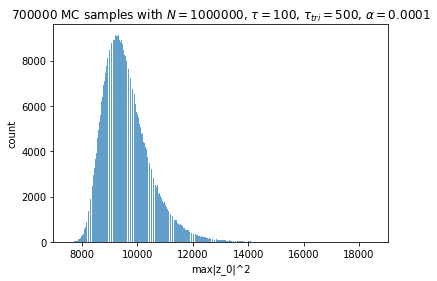

In [6]:
hann2k6stats = get_H0stats_file('max10e6hann2000stats169.csv', N=1000000, \
                                tau=100, tautri=500, alpha=0.0001)

20000  samples of N= 1000000 , tau= 100 , tau_{tri}= 500 , alpha= 0.0001 
[bar, alpha_prime, lef_N] = 
 [15023.622189070411, 1.6701785997995117e-10, 1.6701785997995117e-06]


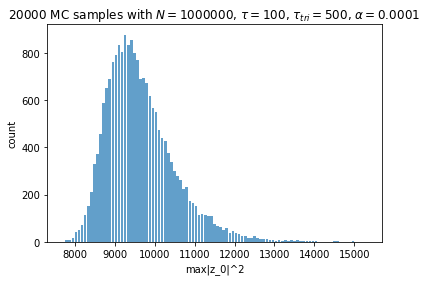

In [72]:
hann5k6stats = get_H0stats_file('max10e6hann5000stats_100_102.csv', N=1000000, \
                                tau=100, tautri=500, alpha=0.0001)

20000  samples of N= 1000000 , tau= 100 , tau_{tri}= 500 , alpha= 0.0001 
[bar, alpha_prime, lef_N] = 
 [15410.549775855205, 9.353064944007423e-11, 9.353064944007423e-07]


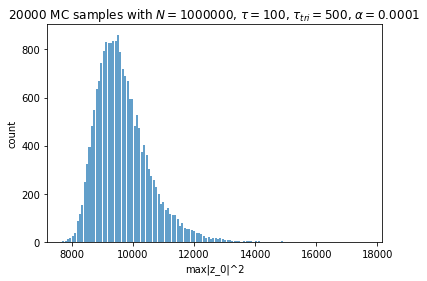

In [73]:
hann10k6stats = get_H0stats_file('max10e6hann10000stats_100_102.csv', N=1000000, \
                                 tau=100, tautri=500, alpha=0.0001)

so, we see that the detection bar is within a percent of the bar set with the exact psd, and the computed test statistics under injection agree with the exact computation to within a percent, and thus we conclude that this estimation WILL NOT HAMPER DETECTION

********
c) $\textbf{Suppose instead of 10^6 samples, you have only 10^4 samples,}$ 

$\textbf{how does this impact the precision of estimating the filter?}$

$\textbf{Is this hampering detection at all?}$
********

if we only have $10^4$ samples, then the resolution of our psd estimate will be reduced, and the more that we want to keep the variance down, the larger the reduction in precision will have to be

let's see what our sensitivity looks like for the hanning, tukey, and gaussian windows at a few different resolutions

In [29]:
nn = 10**4
tau = 100
tautri = 500
tt_ft = np.fft.fft(get_tri_right(nn,tautri))
revsig_ft_cc = np.conj(get_revsig_ft(nn, tau))
sigma_ft_cc = revsig_ft_cc / abs2(tt_ft)
tru_stats = np.empty(((10,3,3)))
ogauss1000s50 = window(('gaussian', 50), 1000)
ogauss1000s100 = window(('gaussian', 100), 1000)
ogauss1000s200 = window(('gaussian', 200), 1000)
ogauss500s30 = window(('gaussian', 30), 500)
ogauss500s50 = window(('gaussian', 50), 500)
ogauss500s100 = window(('gaussian', 100), 500)
otukey1000 = window(('tukey', 0.5), 1000)
otukey500 = window(('tukey', 0.5), 500)
ohann1000 = window('hann', 1000)
ohann500 = window('hann', 500)
gauss1000s50 = np.empty((10,3,3))
gauss1000s100 = np.empty((10,3,3))
gauss1000s200 = np.empty((10,3,3))
gauss500s30 = np.empty((10,3,3))
gauss500s50 = np.empty((10,3,3))
gauss500s100 = np.empty((10,3,3))
tukey1000 = np.empty((10,3,3))
tukey500 = np.empty((10,3,3))
hann1000 = np.empty((10,3,3))
hann500 = np.empty((10,3,3))

In [41]:
ns_vals = np.random.randint(0, nn, size=3)
phi_vals = 2*np.pi*np.random.random(3)
sigs = np.empty((3, nn), dtype=np.csingle)
sigs[0] = np.exp(1j*phi_vals[0]) * get_signal(nn, tau, start=ns_vals[0])
sigs[1] = np.exp(1j*phi_vals[1]) * get_signal(nn, tau, start=ns_vals[1])
sigs[2] = np.exp(1j*phi_vals[2]) * get_signal(nn, tau, start=ns_vals[2])
amps = np.array([0.1, 0.2, 0.4])

In [43]:
for ii in np.arange(10):
    # get 10 realizations of noise to average over for each signal
    noise = np.fft.ifft(np.fft.fft(get_wgn(nn)) * tt_ft)
    for jj in np.arange(3):
        # for each noise realization get stat for all signals
        # (there is certainly a more efficient way to implement this)
        for kk in np.arange(3):
            x = noise + amps[kk]*sigs[jj]
            tru_stats[ii,jj,kk] = np.max(abs2(np.fft.ifft(sigma_ft_cc * np.fft.fft(x))))
            gauss1000s50[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, ogauss1000s50)
            gauss1000s100[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, ogauss1000s100)
            gauss1000s200[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, ogauss1000s200)
            gauss500s30[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, ogauss500s30)
            gauss500s50[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, ogauss500s50)
            gauss500s100[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, ogauss500s100)
            tukey1000[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, otukey1000)
            tukey500[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, otukey500)
            hann1000[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, ohann1000)
            hann500[ii,jj,kk] = compute_stat_welch(x, revsig_ft_cc, ohann500)

In [53]:
tru_statsavg = np.sum(np.sum(tru_stats, axis=0), axis=0)/30
gauss1000s50avg = np.sum(np.sum(gauss1000s50, axis=0), axis=0)/30
gauss1000s100avg = np.sum(np.sum(gauss1000s100, axis=0), axis=0)/30
gauss1000s200avg = np.sum(np.sum(gauss1000s200, axis=0), axis=0)/30
gauss500s30avg = np.sum(np.sum(gauss500s30, axis=0), axis=0)/30
gauss500s50avg = np.sum(np.sum(gauss500s50, axis=0), axis=0)/30
gauss500s100avg = np.sum(np.sum(gauss500s100, axis=0), axis=0)/30
tukey1000avg = np.sum(np.sum(tukey1000, axis=0), axis=0)/30
tukey500avg = np.sum(np.sum(tukey500, axis=0), axis=0)/30
hann1000avg = np.sum(np.sum(hann1000, axis=0), axis=0)/30
hann500avg = np.sum(np.sum(hann500, axis=0), axis=0)/30

In [54]:
rownames = ['exact', 'gauss0', 'gauss1', 'gauss2', 'tukey', 'hann']
colnames = ['L=1000, A=.1','L=1000, A=.2','L=1000, A=.4', \
            'L=500, A=.1','L=500, A=.2','L=500, A=.4']
celltext = [[fmt(zz) for zz in tru_statsavg], [fmt(zz) for zz in gauss1000s50avg], \
            [fmt(zz) for zz in gauss1000s100avg], [fmt(zz) for zz in gauss1000s200avg], \
            [fmt(zz) for zz in tukey1000avg], [fmt(zz) for zz in hann1000avg]]
celltext[0] += [fmt(zz) for zz in tru_statsavg]
celltext[1] += [fmt(zz) for zz in gauss500s30avg]
celltext[2] += [fmt(zz) for zz in gauss500s50avg]
celltext[3] += [fmt(zz) for zz in gauss500s100avg]
celltext[4] += [fmt(zz) for zz in tukey500avg]
celltext[5] += [fmt(zz) for zz in hann500avg]

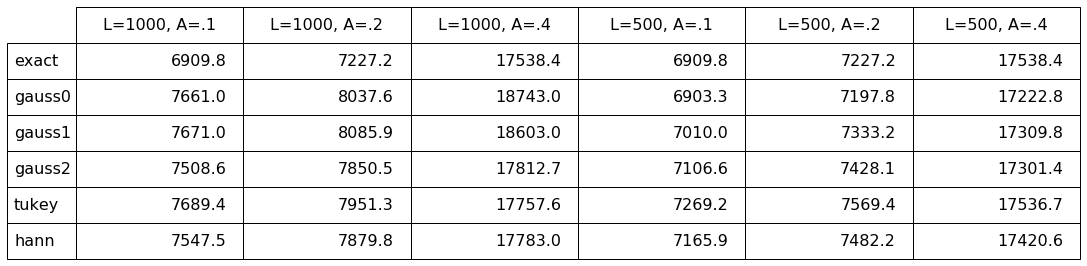

In [55]:
fig, ax = plt.subplots()
ax.axis('off')
the_table = plt.table(cellText=celltext, rowLabels=rownames, colLabels=colnames, loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)
the_table.scale(3, 3)

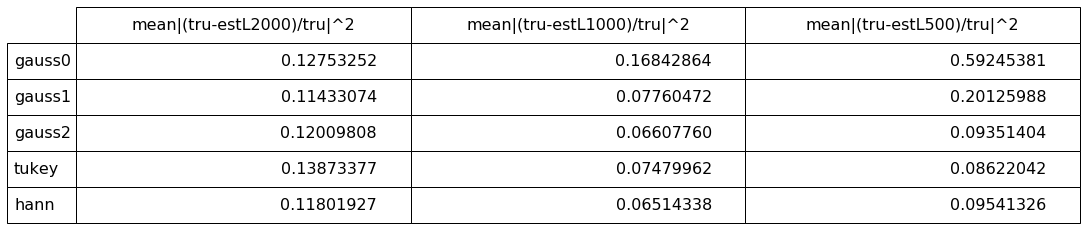

In [30]:
def fmt(num):
    return '{:.8f}'.format(num)

msegauss2000s100 = 0.0
msegauss2000s200 = 0.0
msegauss2000s400 = 0.0
msegauss1000s50 = 0.0
msegauss1000s100 = 0.0
msegauss1000s200 = 0.0
msegauss500s30 = 0.0
msegauss500s50 = 0.0
msegauss500s100 = 0.0
msetukey2000 = 0.0
msetukey1000 = 0.0
msetukey500 = 0.0
msehann2000 = 0.0
msehann1000 = 0.0
msehann500 = 0.0
nn = 10**4
tau = 100
tautri = 500
tt_ft = np.fft.fft(get_tri_right(nn,tautri))
tt_psd = abs2(tt_ft)
cc = 1.0/(nn*1000.0)
for ii in np.arange(1000):
    # get 1000 realizations of noise to average over for psd
    x = np.fft.ifft(np.fft.fft(get_wgn(nn)) * tt_ft)
    msegauss2000s100 += np.sum(compute_msfe_welch(x, tt_psd, ogauss2000s100))*cc
    msegauss2000s200 += np.sum(compute_msfe_welch(x, tt_psd, ogauss2000s200))*cc
    msegauss2000s400 += np.sum(compute_msfe_welch(x, tt_psd, ogauss2000s400))*cc
    msegauss1000s50 += np.sum(compute_msfe_welch(x, tt_psd, ogauss1000s50))*cc
    msegauss1000s100 += np.sum(compute_msfe_welch(x, tt_psd, ogauss1000s100))*cc
    msegauss1000s200 += np.sum(compute_msfe_welch(x, tt_psd, ogauss1000s200))*cc
    msegauss500s30 += np.sum(compute_msfe_welch(x, tt_psd, ogauss500s30))*cc
    msegauss500s50 += np.sum(compute_msfe_welch(x, tt_psd, ogauss500s50))*cc
    msegauss500s100 += np.sum(compute_msfe_welch(x, tt_psd, ogauss500s100))*cc
    msetukey2000 += np.sum(compute_msfe_welch(x, tt_psd, otukey2000))*cc
    msetukey1000 += np.sum(compute_msfe_welch(x, tt_psd, otukey1000))*cc
    msetukey500 += np.sum(compute_msfe_welch(x, tt_psd, otukey500))*cc
    msehann2000 += np.sum(compute_msfe_welch(x, tt_psd, ohann2000))*cc
    msehann1000 += np.sum(compute_msfe_welch(x, tt_psd, ohann1000))*cc
    msehann500 += np.sum(compute_msfe_welch(x, tt_psd, ohann500))*cc
    
msfe_data = [[fmt(msegauss2000s100),fmt(msegauss1000s50),fmt(msegauss500s30)],\
             [fmt(msegauss2000s200),fmt(msegauss1000s100),fmt(msegauss500s50)],
             [fmt(msegauss2000s400),fmt(msegauss1000s200),fmt(msegauss500s100)],
             [fmt(msetukey2000),fmt(msetukey1000),fmt(msetukey500)],
             [fmt(msehann2000),fmt(msehann1000),fmt(msehann500)]]
rownames = ['gauss0', 'gauss1', 'gauss2', 'tukey', 'hann']
fig, ax = plt.subplots()
ax.axis('off')
the_table = plt.table(cellText=msfe_data, rowLabels=rownames, \
                      colLabels=['mean|(tru-estL2000)/tru|^2','mean|(tru-estL1000)/tru|^2',\
                                 'mean|(tru-estL500)/tru|^2'],loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)
the_table.scale(3, 3)

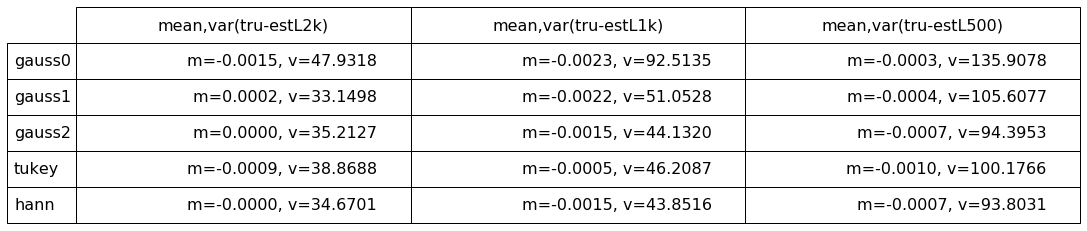

In [31]:
def fmt2(nums):
    return 'm={:.4f}, v={:.4f}'.format(nums[0], nums[1])

mvgauss2000s100 = np.zeros(2)
mvgauss2000s200 = np.zeros(2)
mvgauss2000s400 = np.zeros(2)
mvgauss1000s50 = np.zeros(2)
mvgauss1000s100 = np.zeros(2)
mvgauss1000s200 = np.zeros(2)
mvgauss500s30 = np.zeros(2)
mvgauss500s50 = np.zeros(2)
mvgauss500s100 = np.zeros(2)
mvtukey2000 = np.zeros(2)
mvtukey1000 = np.zeros(2)
mvtukey500 = np.zeros(2)
mvhann2000 = np.zeros(2)
mvhann1000 = np.zeros(2)
mvhann500 = np.zeros(2)
nn = 10**4
tau = 100
tautri = 500
tt_ft = np.fft.fft(get_tri_right(nn,tautri))
tt_psd = abs2(tt_ft)
for ii in np.arange(1000):
    # get 1000 realizations of noise to average over
    x = np.fft.ifft(np.fft.fft(get_wgn(nn)) * tt_ft)
    mvgauss2000s100 += compute_mean_var_welch(x, tt_psd, ogauss2000s100)*0.001
    mvgauss2000s200 += compute_mean_var_welch(x, tt_psd, ogauss2000s200)*0.001
    mvgauss2000s400 += compute_mean_var_welch(x, tt_psd, ogauss2000s400)*0.001
    mvgauss1000s50 += compute_mean_var_welch(x, tt_psd, ogauss1000s50)*0.001
    mvgauss1000s100 += compute_mean_var_welch(x, tt_psd, ogauss1000s100)*0.001
    mvgauss1000s200 += compute_mean_var_welch(x, tt_psd, ogauss1000s200)*0.001
    mvgauss500s30 += compute_mean_var_welch(x, tt_psd, ogauss500s30)*0.001
    mvgauss500s50 += compute_mean_var_welch(x, tt_psd, ogauss500s50)*0.001
    mvgauss500s100 += compute_mean_var_welch(x, tt_psd, ogauss500s100)*0.001
    mvtukey2000 += compute_mean_var_welch(x, tt_psd, otukey2000)*0.001
    mvtukey1000 += compute_mean_var_welch(x, tt_psd, otukey1000)*0.001
    mvtukey500 += compute_mean_var_welch(x, tt_psd, otukey500)*0.001
    mvhann2000 += compute_mean_var_welch(x, tt_psd, ohann2000)*0.001
    mvhann1000 += compute_mean_var_welch(x, tt_psd, ohann1000)*0.001
    mvhann500 += compute_mean_var_welch(x, tt_psd, ohann500)*0.001
    
msfe_data = [[fmt2(mvgauss2000s100),fmt2(mvgauss1000s50),fmt2(mvgauss500s30)],\
             [fmt2(mvgauss2000s200),fmt2(mvgauss1000s100),fmt2(mvgauss500s50)],
             [fmt2(mvgauss2000s400),fmt2(mvgauss1000s200),fmt2(mvgauss500s100)],
             [fmt2(mvtukey2000),fmt2(mvtukey1000),fmt2(mvtukey500)],
             [fmt2(mvhann2000),fmt2(mvhann1000),fmt2(mvhann500)]]
rownames = ['gauss0', 'gauss1', 'gauss2', 'tukey', 'hann']
fig, ax = plt.subplots()
ax.axis('off')
the_table = plt.table(cellText=msfe_data, rowLabels=rownames, \
                      colLabels=['mean,var(tru-estL2k)','mean,var(tru-estL1k)',\
                                 'mean,var(tru-estL500)'], loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)
the_table.scale(3, 3)

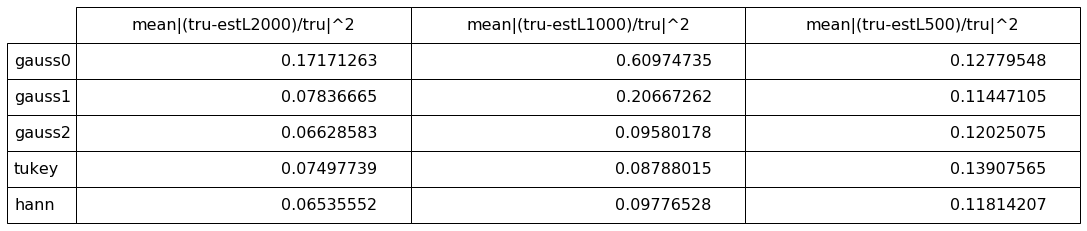

In [58]:
# NOW WITH INJECTED SIGNAL

def fmt(num):
    return '{:.8f}'.format(num)

msegauss2000s100 = 0.0
msegauss2000s200 = 0.0
msegauss2000s400 = 0.0
msegauss1000s50 = 0.0
msegauss1000s100 = 0.0
msegauss1000s200 = 0.0
msegauss500s30 = 0.0
msegauss500s50 = 0.0
msegauss500s100 = 0.0
msetukey2000 = 0.0
msetukey1000 = 0.0
msetukey500 = 0.0
msehann2000 = 0.0
msehann1000 = 0.0
msehann500 = 0.0
nn = 10**4
tau = 100
tautri = 500
tt_ft = np.fft.fft(get_tri_right(nn,tautri))
tt_psd = abs2(tt_ft)
cc = 1.0/(nn*1000.0)
for ii in np.arange(1000):
    # get 1000 realizations of noise to average over for psd
    x = (np.fft.ifft(np.fft.fft(get_wgn(nn)) * tt_ft) + csig(0.3, nn, tau)
    msegauss2000s100 += np.sum(compute_msfe_welch(x, tt_psd, ogauss2000s100))*cc
    msegauss2000s200 += np.sum(compute_msfe_welch(x, tt_psd, ogauss2000s200))*cc
    msegauss2000s400 += np.sum(compute_msfe_welch(x, tt_psd, ogauss2000s400))*cc
    msegauss1000s50 += np.sum(compute_msfe_welch(x, tt_psd, ogauss1000s50))*cc
    msegauss1000s100 += np.sum(compute_msfe_welch(x, tt_psd, ogauss1000s100))*cc
    msegauss1000s200 += np.sum(compute_msfe_welch(x, tt_psd, ogauss1000s200))*cc
    msegauss500s30 += np.sum(compute_msfe_welch(x, tt_psd, ogauss500s30))*cc
    msegauss500s50 += np.sum(compute_msfe_welch(x, tt_psd, ogauss500s50))*cc
    msegauss500s100 += np.sum(compute_msfe_welch(x, tt_psd, ogauss500s100))*cc
    msetukey2000 += np.sum(compute_msfe_welch(x, tt_psd, otukey2000))*cc
    msetukey1000 += np.sum(compute_msfe_welch(x, tt_psd, otukey1000))*cc
    msetukey500 += np.sum(compute_msfe_welch(x, tt_psd, otukey500))*cc
    msehann2000 += np.sum(compute_msfe_welch(x, tt_psd, ohann2000))*cc
    msehann1000 += np.sum(compute_msfe_welch(x, tt_psd, ohann1000))*cc
    msehann500 += np.sum(compute_msfe_welch(x, tt_psd, ohann500))*cc
    
msfe_data = [[fmt(msegauss2000s100),fmt(msegauss1000s50),fmt(msegauss500s30)],\
             [fmt(msegauss2000s200),fmt(msegauss1000s100),fmt(msegauss500s50)],
             [fmt(msegauss2000s400),fmt(msegauss1000s200),fmt(msegauss500s100)],
             [fmt(msetukey2000),fmt(msetukey1000),fmt(msetukey500)],
             [fmt(msehann2000),fmt(msehann1000),fmt(msehann500)]]
rownames = ['gauss0', 'gauss1', 'gauss2', 'tukey', 'hann']
fig, ax = plt.subplots()
ax.axis('off')
the_table = plt.table(cellText=msfe_data, rowLabels=rownames, \
                      colLabels=['mean|(tru-estL2000)/tru|^2','mean|(tru-estL1000)/tru|^2',\
                                 'mean|(tru-estL500)/tru|^2'],loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)
the_table.scale(3, 3)

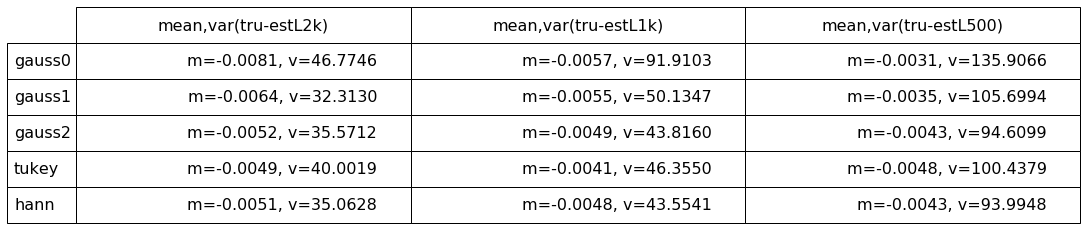

In [32]:
def fmt2(nums):
    return 'm={:.4f}, v={:.4f}'.format(nums[0], nums[1])

mvgauss2000s100 = np.zeros(2)
mvgauss2000s200 = np.zeros(2)
mvgauss2000s400 = np.zeros(2)
mvgauss1000s50 = np.zeros(2)
mvgauss1000s100 = np.zeros(2)
mvgauss1000s200 = np.zeros(2)
mvgauss500s30 = np.zeros(2)
mvgauss500s50 = np.zeros(2)
mvgauss500s100 = np.zeros(2)
mvtukey2000 = np.zeros(2)
mvtukey1000 = np.zeros(2)
mvtukey500 = np.zeros(2)
mvhann2000 = np.zeros(2)
mvhann1000 = np.zeros(2)
mvhann500 = np.zeros(2)
nn = 10**4
tau = 100
tautri = 500
tt_ft = np.fft.fft(get_tri_right(nn,tautri))
tt_psd = abs2(tt_ft)
for ii in np.arange(1000):
    # get 1000 realizations of noise to average over
    x = np.fft.ifft(np.fft.fft(get_wgn(nn)) * tt_ft) + csig(0.3, nn, tau)
    mvgauss2000s100 += compute_mean_var_welch(x, tt_psd, ogauss2000s100)*0.001
    mvgauss2000s200 += compute_mean_var_welch(x, tt_psd, ogauss2000s200)*0.001
    mvgauss2000s400 += compute_mean_var_welch(x, tt_psd, ogauss2000s400)*0.001
    mvgauss1000s50 += compute_mean_var_welch(x, tt_psd, ogauss1000s50)*0.001
    mvgauss1000s100 += compute_mean_var_welch(x, tt_psd, ogauss1000s100)*0.001
    mvgauss1000s200 += compute_mean_var_welch(x, tt_psd, ogauss1000s200)*0.001
    mvgauss500s30 += compute_mean_var_welch(x, tt_psd, ogauss500s30)*0.001
    mvgauss500s50 += compute_mean_var_welch(x, tt_psd, ogauss500s50)*0.001
    mvgauss500s100 += compute_mean_var_welch(x, tt_psd, ogauss500s100)*0.001
    mvtukey2000 += compute_mean_var_welch(x, tt_psd, otukey2000)*0.001
    mvtukey1000 += compute_mean_var_welch(x, tt_psd, otukey1000)*0.001
    mvtukey500 += compute_mean_var_welch(x, tt_psd, otukey500)*0.001
    mvhann2000 += compute_mean_var_welch(x, tt_psd, ohann2000)*0.001
    mvhann1000 += compute_mean_var_welch(x, tt_psd, ohann1000)*0.001
    mvhann500 += compute_mean_var_welch(x, tt_psd, ohann500)*0.001
    
msfe_data = [[fmt2(mvgauss2000s100),fmt2(mvgauss1000s50),fmt2(mvgauss500s30)],\
             [fmt2(mvgauss2000s200),fmt2(mvgauss1000s100),fmt2(mvgauss500s50)],
             [fmt2(mvgauss2000s400),fmt2(mvgauss1000s200),fmt2(mvgauss500s100)],
             [fmt2(mvtukey2000),fmt2(mvtukey1000),fmt2(mvtukey500)],
             [fmt2(mvhann2000),fmt2(mvhann1000),fmt2(mvhann500)]]
rownames = ['gauss0', 'gauss1', 'gauss2', 'tukey', 'hann']
fig, ax = plt.subplots()
ax.axis('off')
the_table = plt.table(cellText=msfe_data, rowLabels=rownames, \
                      colLabels=['mean,var(tru-estL2k)','mean,var(tru-estL1k)',\
                                 'mean,var(tru-estL500)'], loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)
the_table.scale(3, 3)

it appears that hanning is the best estimate again, and let's see what the detection bars look like for each resolution

1000000  samples of N= 10000 , tau= 100 , tau_{tri}= 500 , alpha= 0.0001 
[bar, alpha_prime, lef_N] = 
 [15466.73507016342, 8.597834277682242e-11, 8.597834277682242e-07]


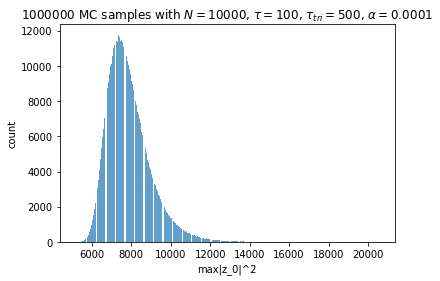

In [25]:
hann2000e4stats = get_H0stats_file('max10e4hann2000stats1M.csv', N=10000, \
                                   tau=100, tautri=500, alpha=0.0001)

1000000  samples of N= 10000 , tau= 100 , tau_{tri}= 500 , alpha= 0.0001 
[bar, alpha_prime, lef_N] = 
 [13328.705722158029, 2.1173818291439715e-09, 2.1173818291439713e-05]


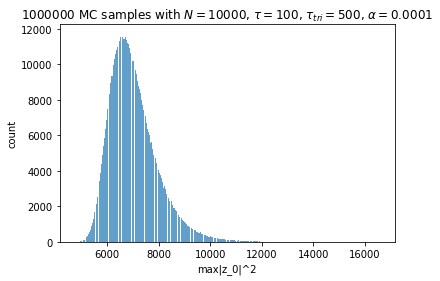

In [26]:
hann1000e4stats = get_H0stats_file('max10e4hann1000stats1M.csv', N=10000, \
                                   tau=100, tautri=500, alpha=0.0001)

1000000  samples of N= 10000 , tau= 100 , tau_{tri}= 500 , alpha= 0.0001 
[bar, alpha_prime, lef_N] = 
 [12792.880364143695, 4.726171379029973e-09, 4.726171379029973e-05]


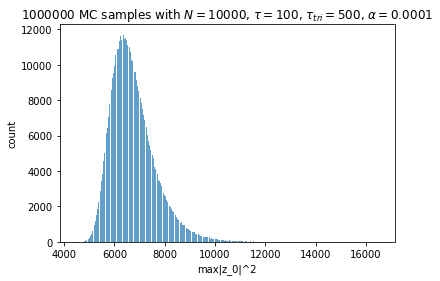

In [27]:
hann500e4stats = get_H0stats_file('max10e4hann500stats1M.csv', N=10000, \
                                  tau=100, tautri=500, alpha=0.0001)

1000000  samples of N= 10000 , tau= 100 , tau_{tri}= 500 , alpha= 0.0001 
[bar, alpha_prime, lef_N] = 
 [12229.700782277057, 1.099060578619609e-08, 0.0001099060578619609]


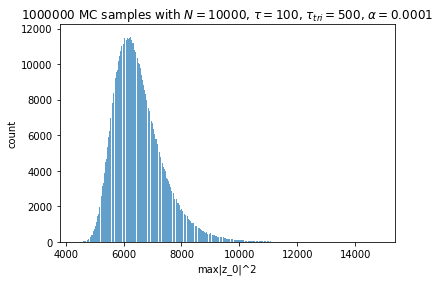

In [70]:
# now comparing to case of exact psd
exacte4stats = get_H0stats_file('max10e4t100tt500stats1M.csv', N=10000, \
                                tau=100, tautri=500, alpha=0.0001)

not only is the variance of the estimate problematic, but also the detection bar set for any resolution is between 5% and 25% higher than if we were to use the exact psd, so when we have only $10^4$ samples estimating the psd DOES HAMPER DETECTION

********
4) Suppose you have the same situation as in (2), but after generating the noise, Gargamel chooses at random 10**3 samples and zeroizes them.
********

In [74]:
# randomly choose 1000 samples to zero
def noise_1k0(N, tautri=500):
    noise = ifft(fft(get_tri_right(N, tautri)) * fft(get_wgn(N)))
    inds = np.arange(N, dtype=int)
    np.random.shuffle(inds)
    noise[inds[:1000]] = 0
    return noise

# randomly choose starting point and zero 1000 consecutive samples
def noise_1k0together(N, tautri=500):
    noise = ifft(fft(get_tri_right(N, tautri)) * fft(get_wgn(N)))
    ind0 = np.random.randint(0, N-1000)
    noise[ind0:ind0+1000] = 0
    return noise

********
a) $\textbf{Compute the statistic from (2) in this situation, and plot their histogram.}$

$\textbf{Is that the same histogram as in (2)? Would this interfere with detection?}$
********

********
b) $\textbf{Write the time-domain statistic relevant for detecting a signal}$

$\textbf{at a particular place, taking the missing data into account.}$
********